# Monografía final

### Presentado por: Ivancovish J. Huancco Mamani

## INTRODUCCIÓN

Un chip semiconductor es un circuito eléctrico con muchos componentes, como transistores y cableado. Aunque la superficie de los chips parece lisa, están construidos físicamente por estructuras tridimensionales y normalmente incluyen muchas capas de circuitos complejos. El proceso de fabricación de semiconductores se produce en una sala limpia en la que se controlan la temperatura, la presión barométrica y la humedad para evitar la contaminación. Un proceso de fabricación típico a menudo implica cientos de pasos de procesamiento que se ejecutan capa por capa en una oblea desnuda, que puede contener cientos de chips (también llamados muere). (Más detalles en la monografia)

Todo el proceso se compone de unos pocos procesos unitarios repetidos: película fina, fotolitografía, planarización química mecánica, difusión, implantación de iones y grabado. La Figura 1 es un flujo de proceso general para la mayoría de la fabricación de semiconductores para ilustrar la interrelación entre estos procesos unitarios.

Esta naturaleza de la fabricación de semiconductores conduce a tiempos de ciclo prolongados y afecta los cambios de tamaño de la oblea no solo debido a la mejora del rendimiento, sino también a la reducción del costo de producción por chip, por lo que se utiliza el mismo número de pasos del proceso para producir más chips.

Primero importamos las librerías principales.


In [1]:
import pandas as pd
import numpy as np
import os
import missingno as msno
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import matplotlib.pyplot as plt
%matplotlib inline

La data fue almacenada en formato .csv lo cual vamos a exportarla de la siguiente forma.

Se utiliza un conjunto de datos de los procesos de prueba y ensamblaje de semiconductores para evaluar el método de predicción de selección de modelos. La variable de respuesta se refiere a la tasa de rendimiento de una combinación específica de máquina y producto en uno de los pasos del proceso de ensamblaje y prueba según los datos históricos. Este conjunto de datos incluye 1 variable de respuesta, 5 atributos categóricos de máquina y producto y 11 atributos numéricos. El conjunto de datos contiene 13186 observaciones.

Los cinco atributos categóricos representan los tipos de máquina, producto, material, paquete y receta que son factores clave que afectan las tasas de producción registradas por el Sistema de Ejecución de Fabricación (SEF) durante la producción. Los 11 atributos numéricos representan las características geométricas y físicas de un chip semiconductor, como el espesor de rectificado, el número de cables, el ancho y la longitud del cable, el número de troqueles en un sustrato, el número de conductores, el tamaño del troquel 2D y el tamaño del paquete 3D. La variable de respuesta se refiere a la tasa de rendimiento de una combinación específica de máquina-producto durante la producción.

- X1: Maquina
- X2: Producto
- X3: Material
- X4: Paquete
- X5: Recipiente para un numero n de obleas
- X6: Espesor de Rectificado
- X7: Número de cables
- X8: Ancho del cable
- X9: Longitud del cable
- X10: Número de Troqueles en un sustrato
- X11: Número de conductores
- X12: Tamaño del troquel eje-x
- X13: Tamaño del troquel eje-y
- X14: Tamaño del paquete eje-x
- X15: Tamaño del paquete eje-y
- X16: Tamaño del paquete eje-z
- lotName: Número de lote
- wafer_id: indice de oblea
- dieSize: Medida de troquel
- Pred: Predicción del oblea
- Real: Tipo de oblea aproximada
- Center: dimensión de oblea central
- Donut: dimensión de oblea tipo rosquilla
- Edge-Loc: dimensión de oblea localizada en el borde
- Edge-Ring: dimensión de oblea tipo anillo en el borde
- Loc: dimensión de oblea local
- Near-Full: dimensión de oblea casi llena
- Random: dimensión de oblea aleatoria sin forma
- Scratch: dimensión de oblea tipo rayadura










- Y: Pass/Fail. Obtenido de la tasa de rendimiento de una combinación específica de máquina-producto y tipo de oblea durante la producción.

# Seleccion de Data

El conjunto de datos comprende 8000 mapas de obleas, junto con información adicional como el tamaño del troquel de obleas (dieSize), el nombre del lote y el índice de obleas. (data obtenida a traves de la empresa en donde laboro, Dedicado a la manufactura, Calibración, Intrumentación entre otros)

El conjunto de entrenamiento / prueba ya fue dividido por expertos en el dominio, pero en este kernel ignoramos esta información y re-dividimos el conjunto de datos en conjunto de entrenamiento y conjunto de prueba por método de retención que se presentará en la sección posterior.

In [2]:
df_sem=pd.read_csv("sem_data.csv")

In [3]:
df_sem.columns

Index(['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'lotName', 'wafer_id', 'dieSize',
       'Real', 'Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch'],
      dtype='object')

El conjunto de datos se recopiló de 475 lotes en fabricacion del mundo real. Sin embargo, 475 lotes x 25 obleas / lote = 11875 mapas de obleas es más grande que 8000 mapas de obleas.

Vamos a ver que pasó.

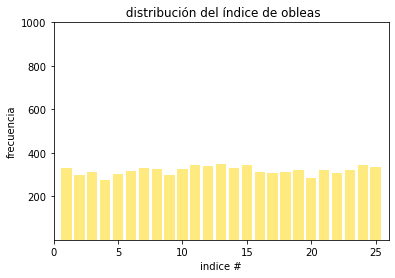

In [4]:
uni_Index=np.unique(df_sem.wafer_id, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" distribución del índice de obleas")
plt.xlabel("indice #")
plt.ylabel("frecuencia")
plt.xlim(0,26)
plt.ylim(1,1000)
plt.show()

La figura muestra que no todos los lotes tienen mapas de 25 obleas perfectos y esto puede deberse a fallas del sensor u otros problemas desconocidos.

Afortunadamente, no necesitamos la función de índice de obleas en nuestra clasificación, por lo que podemos eliminar la variable.

Tampoco requerimos el uso de "LotName" es basicamente la identificacion de cada lote y "X5" que el tipo de recipiente para un numero de oblea n (n=1,2,...,25)

In [5]:
df = df_sem.drop(['wafer_id',"lotName","X5"], axis = 1)

# Identificación de valores Faltantes

Como paso fundamental y principal es verificar si existen datos faltantes dento de nuestra tabla de datos. Existen varios métodos para realizar esta inspección aquí vamos a mencionar 3 en particular:

## Consulta si falta dato en cada columna

Devuelve True o False si existe o no valores faltantes

In [6]:
df.isnull().any()

Y            False
X1           False
X2           False
X3           False
X4           False
X6           False
X7           False
X8           False
X9           False
X10          False
X11          False
X12          False
X13          False
X14          False
X15          False
X16          False
dieSize      False
Real         False
Center       False
Donut        False
Edge-Loc     False
Edge-Ring    False
Loc          False
Near-full    False
Random       False
Scratch      False
dtype: bool

## A través de una libreria 'missingno' 

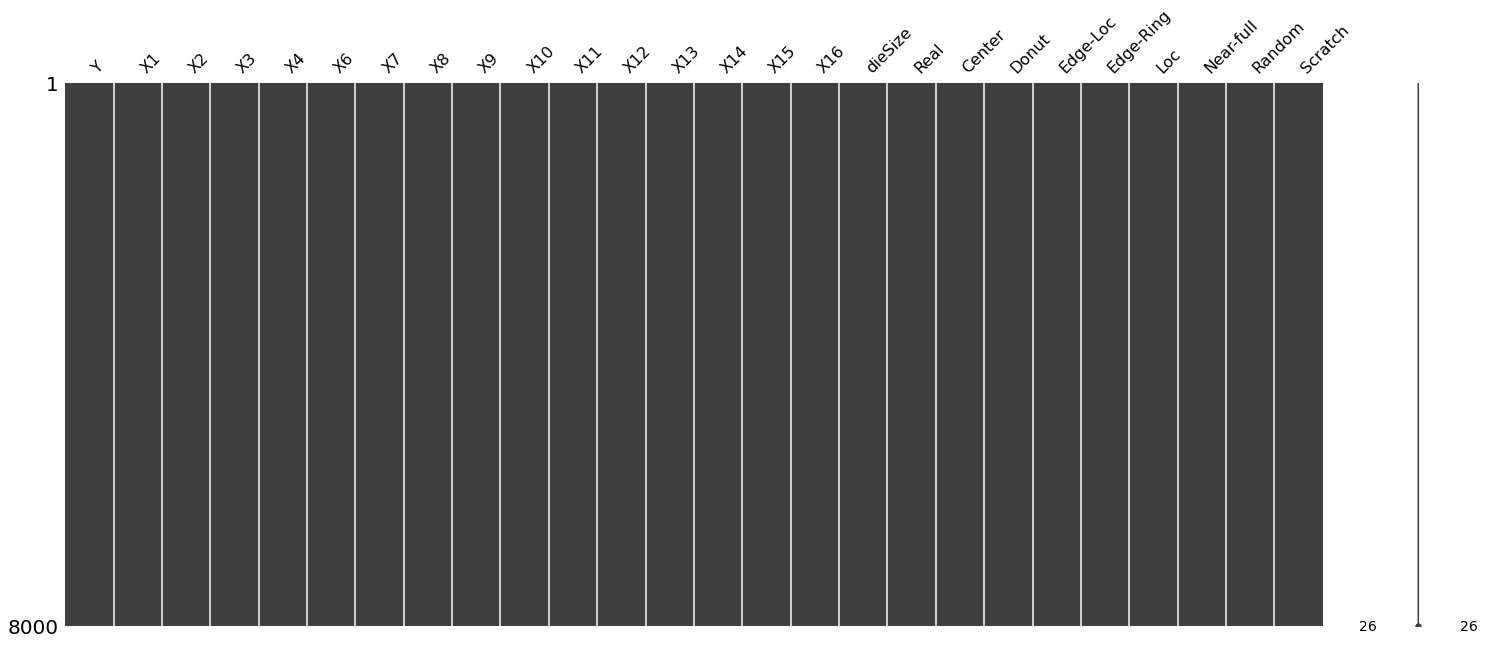

In [7]:
msno.matrix(df)

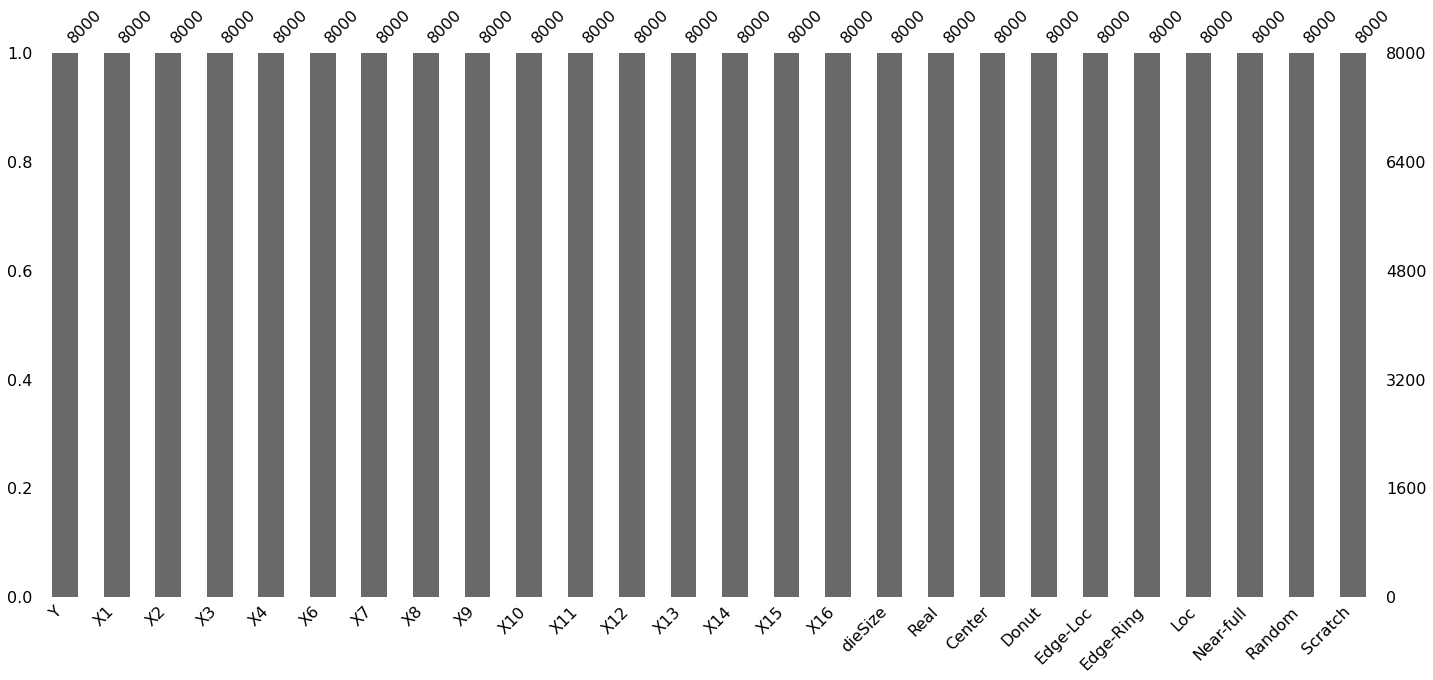

In [8]:
msno.bar(df)

Con estos dos metodos no encontramos ningun dato faltante.

Y con la siguiente que ademas nos ofrece el tipo de variable de vada columna

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          8000 non-null   object 
 1   X1         8000 non-null   object 
 2   X2         8000 non-null   object 
 3   X3         8000 non-null   object 
 4   X4         8000 non-null   object 
 5   X6         8000 non-null   float64
 6   X7         8000 non-null   int64  
 7   X8         8000 non-null   int64  
 8   X9         8000 non-null   int64  
 9   X10        8000 non-null   float64
 10  X11        8000 non-null   float64
 11  X12        8000 non-null   float64
 12  X13        8000 non-null   int64  
 13  X14        8000 non-null   int64  
 14  X15        8000 non-null   int64  
 15  X16        8000 non-null   float64
 16  dieSize    8000 non-null   int64  
 17  Real       8000 non-null   object 
 18  Center     8000 non-null   float64
 19  Donut      8000 non-null   float64
 20  Edge-Loc

## Resumen de tipo de variables

> Revisión de variables tipo "object"

Como se puede apreciar existen 6 variables tipo objeto que son "X1", "X2", "X3", "X4", y "Real" que son variables categoricas.


Las cinco variables categóricas 𝑋1, 𝑋2, 𝑋3, 𝑋4, 𝑋5 tienen 2, 3, 4, 7 y 22 valores de atributos categóricos, respectivamente (es decir, $\Omega$1 = {1,2}, $\Omega$2 = {1,2,3}, $\Omega$3 = {1,2,3,4} y $\Omega$4 = {1,2,…, 7}).

In [10]:
df['X1'].unique()

array(['X1-1', 'X1-2'], dtype=object)

In [11]:
df['X2'].unique()

array(['X2-1', 'X2-2', 'X2-3'], dtype=object)

In [12]:
df['X4'].unique()

array(['X4-1', 'X4-2', 'X4-3', 'X4-4', 'X4-5'], dtype=object)

Estas cuatro mencionadas no tienen un peso definido porque son tipo de maquinas, producto, material y paquete

In [13]:
df['X4'].unique()

array(['X4-1', 'X4-2', 'X4-3', 'X4-4', 'X4-5'], dtype=object)

In [14]:
df['Real'].unique()

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch'], dtype=object)

Estas dos variable si tiene un peso determinado, es decir son variables cateogicas ordinales
 - 'X4' representa el material usado (la caracterización del material semiconductor y/o sustrato indica que existe ruido y por ende pasa a ser degradado, lo cual podria ordenarse de 1 a 5 como un grado de pureza.
 - 'Real' Representa la caracteristica de falla mas relevante en que podria ordenar de forma ascendente, siendo Loc la que menos falla tiene y Near-Full la que mas fallas tiene.

> Revisión de variables tipo "float"

Las variables de tipo float que son "X6", "X10", "X11", "X12", "X16", "Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-Full", "Random", "Scratch" son variables numericas

> Revisión de variables tipo "int"

Las variables de tipo int que son "X7", "X8", "X9", "X13", "X14", "X15", "die_Size" son variables numericas

Inspección de variables si cuentan con valores unicos

In [15]:
df['X7'].unique()

array([ 50,  67, 176,  68,  54,  63, 409, 376,  73,  51, 294, 139, 138,
        47,  53,  46, 208, 107, 119, 251, 205, 183, 194, 295, 151,  39,
        19, 420, 188, 479, 484, 252, 504, 331, 127,  56, 197,  72,  70,
        87,  57,  31,  30,  24,  59, 270,  84,  74,  80,  58,  98,  35,
        49, 248, 120,  66, 222,  75,  81, 207, 163, 152, 118, 117,  69,
        79, 136, 141,  89, 134, 556,  77, 157, 130, 131, 116,  93, 106,
       102, 100, 108, 113, 153, 167, 174, 192, 166, 169, 115, 133,  82,
       165, 159, 190, 126, 233, 220, 171, 123,  90, 158, 214, 196, 320,
       140, 377, 272,  94, 191,  76, 271, 187, 334, 186, 203, 150, 236,
       212, 122, 121, 211, 321], dtype=int64)

In [16]:
df['X8'].unique()

array([ 48,  34, 187,  66,  92, 139, 330,  73, 298,  51, 102,  52,  59,
        42, 194,  76,  28, 219, 372, 338, 297, 311,  86, 138,  19, 470,
       247, 274, 444, 495, 279,  84,  41,  31,  85, 133,  50, 231,  47,
        58,  63,  30,  43, 108,  80,  57,  60, 209,  78,  89,  64, 106,
        79, 124,  77, 196,  53,  97, 119, 181,  90,  93, 131, 163, 189,
       154, 122, 130, 125, 128,  98, 545,  74, 169, 120, 127, 105,  83,
       100,  68, 111, 101, 165, 161, 177, 204, 115, 149, 175, 114, 174,
       136, 202, 126, 129, 272, 207, 185, 140, 143, 295, 240, 294, 341,
       123, 141, 494, 220, 208, 357, 320, 230, 260, 176, 258,  67, 103,
        46, 286, 144, 328, 153, 158, 146, 485, 347], dtype=int64)

In [17]:
df['X9'].unique()

array([105, 200, 125, 110, 335, 160,  50, 150, 107, 435, 320, 175, 152,
       250,  55,  60,  65, 180, 127, 114,  75, 100,  76, 750, 254, 203,
       178, 305, 275, 193, 210,  85,  90, 120, 143, 318], dtype=int64)

In [18]:
df['X13'].unique()

array([  8,  26,  12,  41,  28,  16,  34,  44,  20,  78,  96, 132, 169,
       153, 345, 391, 152, 200,  10, 204,  64,  52,  18,  32,  40,  36,
        56,  48,  72,  88,  84,  24, 168,  63, 162,  90,  67,  54,  60],
      dtype=int64)

In [19]:
df['X14'].unique()

array([1600,  216,  832,  240,  120,   56,   72,  126,  238, 1728, 1216,
         80,  168,  140,  180,  150,   48,  175,   95,   90,   60,   30,
         88,  352,  304,  308, 2400,  624, 1596,    4,  108, 1152, 1440,
        440,  160,  288,  125,  100,  104,  256,  156,  224,  144,   64,
        481,   36,   66], dtype=int64)

In [20]:
df['X15'].unique()

array([  8,  10,  32,  27,  97,  29,  86,  24,  59,  20,  38, 206,  78,
        91,  99,  93,  75,  80,   4, 267, 269,  98, 119, 117, 177, 193,
       192, 195, 157, 261,  57, 194,  14,  11,   9,  12, 203,  76,  16,
        15,  33,  34,  36,  31,  37,  39,  46,  42,  58,  52, 109,  60,
        54, 131,  90,  69, 102,  96,  77, 134,  72, 113,  79, 156,  85,
        18,  21,  22,  94,  83,  92,  82,  74,  88,  84, 104,  67, 236,
       132, 111, 140,  30,  28,  25,  19,  65,  63,  55,  66, 108, 139,
       112, 137,  71,  95,  23,  68,  61], dtype=int64)

In [21]:
df['dieSize'].unique()

array([ 1507,  1129,   776,   533,   939,  1522,  1299,  1297,   986,
        3532,  2007,  1145,  2937,  1801,  2393,   710,  4987,  1485,
         515,  3031,  1109,  2000,  1380,   980,   693,   736,  1044,
        2597,   682,  1226,  1724,   549,  1389,  1644,  1880,  1139,
        1334,  2460,  1683,  4251,  4096,  8147,  3797,  3642,   518,
        1080, 13301, 15545,   564,  1530,  1473,  1187,  2071,   733,
        1204,   846,   796,   712,   844,   845,   842,   843,  1233,
         793,   516,  1483,  1256,  1091,   741,   895,  1421,   492,
         904,  1376,  1442,  1466,   953,   562,  1060,   600,  1844,
        3134,  1760,  5019,  1534,  2628,  1623,  1769,  1748,   841,
         837,  1620,  2979,  2990,  3001,  3012,  2268,  4188,   924,
         811,   661,  5133,  1291,  3632,  2340,  5342,  4432,  1169,
        1073,  5633,   959,  1977,  2749,   827,  2096,  2485,  4603,
        4612,  1583,  1893,   592,  2849,  1363,  1391,  2847,  2452,
        2846,   993,

# Tratamiento de valores Atípicos

Una vez identificadas las variables numéricas, hay que tener en cuenta otra característica muy importante,
los valores “outliers”, los cuales se podrían definir como un dato atípico y extremo que se desvía del grupo
de observaciones. Es importante tomar en cuenta estos valores ya que pueden potencialmente afectar los
resultados sobre todo cuando se trabaja con la media.

Uno de los métodos más utilizados para poder identificar los outliers es el uso del Boxplot, el cual permite
ver gráficamente cómo se agrupan los valores tomando de referencia los cuartiles (25%, 50% y 75%). Se
define como valor outlier, aquel que se encuentra fuera del rango inferior del primer cuartil menos 3 veces
el rango intercuartil (diferencia entre el Q1 y Q3) y por encima del rango superior del tercer cuartil más 3
veces el rango intercuartil.

> Visualizando para una variable

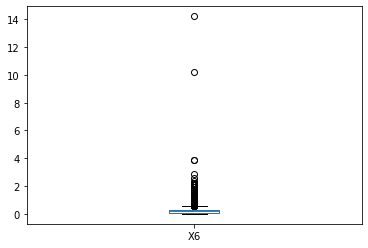

In [22]:
variable_ati_X6="X6"
df_out= pd.concat([df[variable_ati_X6]], axis=1)

#BoxPlot y rango intercuartil
df[variable_ati_X6].plot.box() 

Claramente se ve que existe valores atípicos. Para mejorar esta varaible utilizamos el criterio de rango intercuartilico visto en clase.

In [23]:
#valor outlier
iqr = df[variable_ati_X6].quantile(0.75) - df[variable_ati_X6].quantile(0.25)
df_out["flg_out"]=(df[variable_ati_X6]< np.percentile(df[variable_ati_X6], 25)-1.5*iqr) | (df[variable_ati_X6]> np.percentile(df[variable_ati_X6], 75)+1.5*iqr)

In [24]:
df_out[df_out["flg_out"]==True].count()

X6         1029
flg_out    1029
dtype: int64

In [25]:
df_out[df_out["flg_out"]==False].count()

X6         6971
flg_out    6971
dtype: int64

In [26]:
min_acep= df_out[df_out["flg_out"] ==False].min().iloc[0]
min_acep

8.52e-05

In [27]:
#Acotar valores Outlier con Boxplot
min_acep= df_out[df_out["flg_out"] ==False].min().iloc[0]
max_acep= df_out[df_out["flg_out"] ==False].max().iloc[0]
df_out[df_out[variable_ati_X6]<min_acep] = min_acep
df_out[df_out[variable_ati_X6]>max_acep] = max_acep 

In [28]:
#Verifiacación valores máximo y mínimo
df_out.max().iloc[0]

0.545270289

In [29]:
df_out.min().iloc[0]

8.52e-05

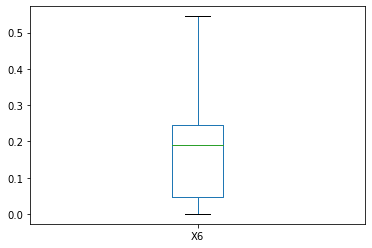

In [30]:
#Boxplot con valores acotados
df_out[variable_ati_X6].plot.box() 

## Otros Métodos de Normalización

Para la misma variable "X6" se van a analizar otros métodos para la
normalización de datos, entre los que destacan el Z-Score, Max-Min, y Sofmax para ver sus características
a la hora de tratar valores outlier

### Z-SCORE

In [31]:
dfframe=pd.DataFrame(df_out[variable_ati_X6])
dfframe

X6
0     0.025286
1     0.034876
2     0.079237
3     0.113288
4     0.113778
...        ...
7995  0.061097
7996  0.061110
7997  0.061120
7998  0.061143
7999  0.061147

[8000 rows x 1 columns]

In [32]:
from sklearn.preprocessing import StandardScaler

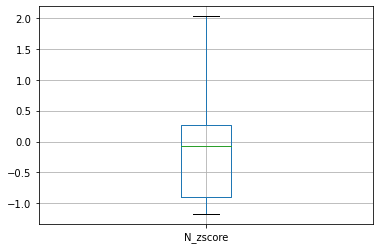

In [33]:
scaler = StandardScaler()
df_out_zs=scaler.fit_transform(dfframe)
df_out_zs=pd.DataFrame(df_out_zs,columns=["N_zscore"])
df_out_zs.boxplot()

### Normalización MIN-MAX

In [34]:
from sklearn.preprocessing import MinMaxScaler

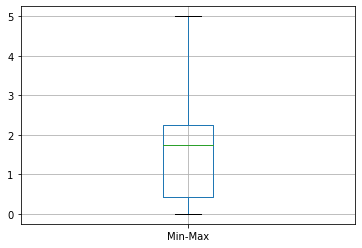

In [35]:
Minmax = MinMaxScaler(feature_range=(0, 5))
df_out_mm=Minmax.fit_transform(dfframe)
df_out_mm=pd.DataFrame(df_out_mm,columns=["Min-Max"])
df_out_mm.boxplot()

### Normalización SOF-MAX

In [36]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

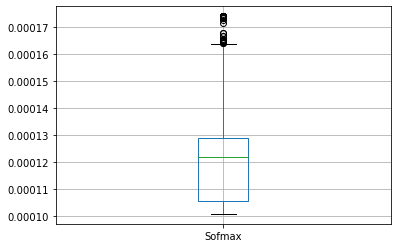

In [37]:
df_out_sm=softmax(dfframe)
df_out_sm=df_out_sm.rename(columns={variable_ati_X6:"Sofmax"})
df_out_sm.boxplot()

Compando Normalizaciones

In [38]:
df_norm=pd.concat([df_out_zs,df_out_mm,df_out_sm],axis=1)
df_norm

N_zscore   Min-Max    Sofmax
0    -1.026474  0.231121  0.000103
1    -0.970151  0.319074  0.000104
2    -0.709622  0.725916  0.000109
3    -0.509641  1.038205  0.000113
4    -0.506764  1.042698  0.000113
...        ...       ...       ...
7995 -0.816155  0.559555  0.000107
7996 -0.816079  0.559673  0.000107
7997 -0.816024  0.559758  0.000107
7998 -0.815888  0.559971  0.000107
7999 -0.815861  0.560014  0.000107

[8000 rows x 3 columns]

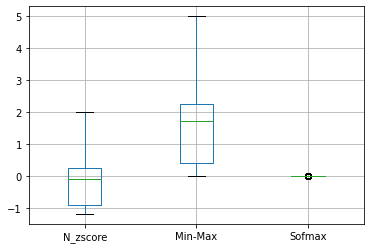

In [39]:
df_norm.boxplot()

La normalización softmax es mas pequeña y varia entre 0 y 1. Por practicidad vamos a elegir el metodo de cuartiles

Aplicando para todas las variables ordinales

In [41]:
df_2=df.copy() #hacemos una copia

In [42]:
#definir función para corrección de outliers
def boxplot_outliers (data, var):
    var_outlier= var
    df_out= pd.concat([data[var_outlier]], axis=1)
    iqr = df_out[var_outlier].quantile(0.75) - df_out[var_outlier].quantile(0.25)
    df_out["flg_out1"]= (df_out[var_outlier]< np.percentile(df_out[var_outlier], 25)-3*iqr)|(df_out[var_outlier]> np.percentile(df_out[var_outlier], 75)+3*iqr)
    min_acep= df_out[df_out["flg_out1"]==False].min().iloc[0]
    max_acep= df_out[df_out["flg_out1"]==False].max().iloc[0]
    df_out[df_out[var_outlier]<min_acep]= min_acep
    df_out[df_out[var_outlier]>max_acep]= max_acep
    data[var_outlier]= df_out[var_outlier]
    return data

In [43]:
variables= pd.DataFrame(df_2.dtypes, columns = ['Tipo']).reset_index()
variables['Tipo_fact']= pd.factorize(variables["Tipo"])[0]
var_cuanti= variables[variables['Tipo_fact'].isin([1,2])]
var_cuanti_l= var_cuanti["index"].tolist()
var_cuanti_l

['X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'dieSize',
 'Center',
 'Donut',
 'Edge-Loc',
 'Edge-Ring',
 'Loc',
 'Near-full',
 'Random',
 'Scratch']

In [44]:
for i in var_cuanti_l:
    boxplot_outliers(df_2, i)

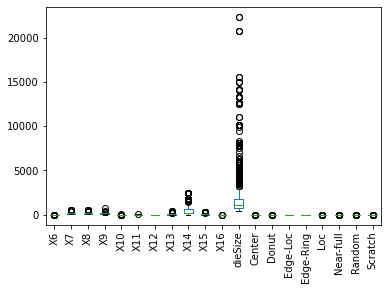

In [45]:
df[var_cuanti_l].plot.box(rot=90)

AHORA VEAMOS LOS DATOS SIN ATIPICOS Y NORMALIZADOS

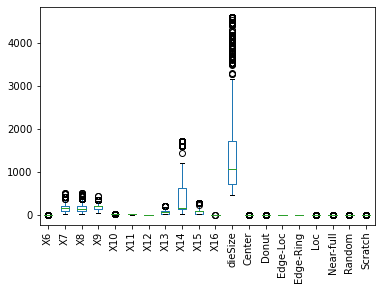

In [46]:
df_2[var_cuanti_l].plot.box(rot=90)

#  Análisis de variables Cuantitativas y Cuantitativas

Para el análisis de variables categóricas o continuas se analizará si estas aportan o no informaciónsuficiente, es importante para predecir la variable objetivo, de este modo se tendrá en cuentasi existen tendencias crecientes y monótonas, además del Weight WOE y el Infomation Value(IV) los cuales son 2 indicadores muy utilizados y que permitirán identificar agrupaciones odescarte de las variables.  Además, del uso de otras técnicas utilizadas frecuentemente talescomo Recursive Feature Elimination (RFE) Random Forest, Chi-Cuadrado entre otros.

Antes de las operaciones cambiamos la variable objetivo a tipo dicotómica 0 y 1.

In [47]:
df_2_Y=df_2['Y'].replace(to_replace=['fail', 'pass'], value=[0,1])
df_2_Y=pd.DataFrame(df_2_Y)
data_2= df_2.assign(Y=df_2_Y['Y']) #Nueva tabla con categoria 0 y 1 en la variable objetivo

## Mediante W0E e IV

El valor de la información es un concepto muy útil para la selección de variables durantela construcción del modelo.  Las raíces del valor de la información, creo, están en la teoríade la información propuesta por Claude Shannon.  La razón de mi creencia es la similitudque tiene el valor de la información con un concepto de entropía ampliamente utilizado enla teoría de la información.  El valor de Chi Cuadrado, una medida ampliamente utilizadaen estadística, es un buen reemplazo para IV (valor de información).  Sin embargo, la IV esuna medida popular y ampliamente utilizada en la industria.  La razón de esto son algunasreglas prácticas muy convenientes para la selección de variables asociadas con IV; estas sonrealmente útiles, como descubrirá más adelante en este artículo http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/.

Para el análisis del WOE e IV creamos una función que nos facilitara el trabajo.

In [48]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    # Marco de datos vacío
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    # Extraer nombres de columnas
    cols = data.columns
    
    # Ejecute WOE y IV en todas las variables independientes
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Frecuencia', 'N', 'Buenos']
        d['% Buenos'] = np.maximum(d['Buenos'], 0.5) / d['Buenos'].sum()
        d['Malos'] = d['N'] - d['Buenos']
        d['% Malos'] = np.maximum(d['Malos'], 0.5) / d['Malos'].sum()
        d['WoE'] = np.log(d['% Buenos']/d['% Malos'])
        d['IV'] = d['WoE'] * (d['% Buenos'] - d['% Malos'])
        d.insert(loc=0, column='Variable', value=ivars)
        print('-'*74)
        print("Information_Value de " + ivars + " es " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        # Muestra la tabla WOE
        if show_woe == True:
            print(d)
    return newDF, woeDF

La variable dependiente especificada en el parámetro de destino debe ser binaria. 1 se refierePass (Bueno) y 0 se refiere a Fail (Malo).


In [49]:
# Evaluación de resultados
iv, woe = iv_woe(data = data_2, target = 'Y', bins=10, show_woe = True)
print('x'*74)
print(iv)
print('x'*74)
print(woe)

--------------------------------------------------------------------------
Information_Value de X1 es 0.273023
  Variable Frecuencia     N  Buenos  % Buenos  Malos   % Malos       WoE  \
0       X1       X1-1  4005    1899  0.396948   2106  0.654851 -0.500602   
1       X1       X1-2  3995    2885  0.603052   1110  0.345149  0.558026   

         IV  
0  0.129106  
1  0.143916  
--------------------------------------------------------------------------
Information_Value de X2 es 0.320548
  Variable Frecuencia     N  Buenos  % Buenos  Malos   % Malos       WoE  \
0       X2       X2-1  1346    1167  0.243938    179  0.055659  1.477667   
1       X2       X2-2  6302    3417  0.714256   2885  0.897077 -0.227901   
2       X2       X2-3   352     200  0.041806    152  0.047264 -0.122702   

         IV  
0  0.278214  
1  0.041665  
2  0.000670  
--------------------------------------------------------------------------
Information_Value de X3 es 0.013415
  Variable Frecuencia     N  Buenos

A partir de estos resultados identificamos los valores realmente relevantes:

| Information Value | Poder predictivo   |
|------|------|
|  < 0,02  | inútil para la predicción |
|   0,02 a 0,1  | Predictor débil |
|   0,1 a 0,3  | Predictor medio |
|   0,3 a 0,5  | Fuerte predictor |
|   > 0,5 | Sospechoso o demasiado bueno para ser verdad |

Las variable mencionadas arriba podrian tranquilamente eliminarse, sin emgargo, con un simple criterio humano y experiencia algunas variables se mantendran intangibles por la contribución inherente que estas conllevan tales como: 'Edge-Ring' y 'Center'.

## Mediante RFE, Random Forest, Chi-cuadrado

Para comparar con otras transformaciones tales como Random_forest, eliminación recursiva entre otros, vamos utilizar un packete muy interesante implementado en python como es xverse https://pypi.org/project/xverse/

In [50]:
from xverse.ensemble import VotingSelector
clf = VotingSelector()
clf.fit(data_2.drop(columns=['Y']), data_2['Y'])

C:\Users\kaize.MSI\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\kaize.MSI\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\kaize.MSI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kaize.MSI\anac

VotingSelector(no_of_features=12,
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

Ahora verificamos las caracterisiticas importantes para análisis

In [51]:
clf.feature_importances_

Variable_Name  Information_Value  Random_Forest  \
0             X6           1.357577       0.098859   
1            X15           1.290650       0.108262   
2            X12           1.138031       0.025089   
3            X14           1.031186       0.051230   
4            X11           0.944744       0.048545   
5            X13           0.812123       0.081825   
6           Real           0.770717       0.111897   
7             X9           0.757490       0.013153   
8             X4           0.719458       0.044180   
9             X7           0.630480       0.034950   
10           X10           0.538633       0.035731   
11     Edge-Ring           0.528251       0.062737   
12        Center           0.440742       0.160650   
13           X16           0.380962       0.007879   
14            X2           0.320548       0.008750   
15            X1           0.273023       0.010641   
16            X8           0.267517       0.012568   
17     Near-full           0.235561       0.001331   
18        Random           0.233621       0.002910   
19           Loc           0.219540       0.010266   
20         Donut           0.203335       0.005278   
21       dieSize           0.191756       0.032753   
22       Scratch           0.167095       0.009619   
23      Edge-Loc           0.060765       0.017080   
24            X3           0.013190       0.003820   

    Recursive_Feature_Elimination  Extra_Trees  Chi_Square     L_One  
0                        4.840418     0.089341  270.883483  0.364056  
1                        0.000000     0.096348  228.129763  0.003690  
2                        5.948022     0.050053  111.716163  0.000000  
3                        0.000000     0.061147  488.036145  0.000047  
4                        0.256102     0.046859  256.416408  0.038715  
5                        0.000000     0.066599  148.476786  0.005791  
6                        1.349613     0.088870  397.737288  0.290998  
7                        0.000000     0.026726   76.683914  0.003160  
8                        1.070691     0.025177  104.501908  0.355089  
9                        0.000000     0.015635   28.403422 -0.003428  
10                      -0.281916     0.037677  169.847254  0.028672  
11                      -1.881008     0.037795  596.289797 -0.242393  
12                       0.000000     0.175424  350.794831  0.000000  
13                      -3.267086     0.015815   21.021684 -1.318194  
14                       1.221464     0.020681  397.339607  0.311541  
15                      -3.924558     0.036361  256.154400 -0.797425  
16                       0.000000     0.016304   51.056799  0.002111  
17                       0.000000     0.006336    2.238279  0.000000  
18                       0.000000     0.007497    0.151012  0.000000  
19                       0.000000     0.015329  114.403458  0.000000  
20                       0.000000     0.009734   32.777136  0.000000  
21                       0.000000     0.010778   82.778727  0.000019  
22                       0.000000     0.010622    0.298397  0.000000  
23                      -1.216565     0.025410   24.629645 -0.210743  
24                       3.279772     0.007485    1.359652  0.000000

en IV no coincidiran algunos valores uno es tipo itearativo y el otro por frecuencias pero son similares

Aplicamos un resumen de conversión para ver en que caracteristias fallan las variables.

In [52]:
clf.feature_votes_

Variable_Name  Information_Value  Random_Forest  \
0             X6                  1              1   
11     Edge-Ring                  1              1   
4            X11                  1              1   
6           Real                  1              1   
10           X10                  1              1   
5            X13                  1              1   
1            X15                  1              1   
15            X1                  0              0   
3            X14                  1              1   
8             X4                  1              1   
14            X2                  0              0   
12        Center                  0              1   
2            X12                  1              0   
9             X7                  1              1   
13           X16                  0              0   
7             X9                  1              0   
23      Edge-Loc                  0              0   
19           Loc                  0              0   
21       dieSize                  0              1   
24            X3                  0              0   
16            X8                  0              0   
17     Near-full                  0              0   
18        Random                  0              0   
20         Donut                  0              0   
22       Scratch                  0              0   

    Recursive_Feature_Elimination  Extra_Trees  Chi_Square  L_One  Votes  
0                               1            1           1      1      6  
11                              1            1           1      1      6  
4                               1            1           1      1      6  
6                               1            1           1      1      6  
10                              1            1           1      1      6  
5                               0            1           1      1      5  
1                               0            1           1      1      5  
15                              1            1           1      1      4  
3                               0            1           1      0      4  
8                               1            0           0      1      4  
14                              1            0           1      1      3  
12                              0            1           1      0      3  
2                               1            1           0      0      3  
9                               0            0           0      0      2  
13                              1            0           0      1      2  
7                               0            1           0      0      2  
23                              1            0           0      1      2  
19                              0            0           1      0      1  
21                              0            0           0      0      1  
24                              1            0           0      0      1  
16                              0            0           0      0      0  
17                              0            0           0      0      0  
18                              0            0           0      0      0  
20                              0            0           0      0      0  
22                              0            0           0      0      0

Deacuerdo ocn la columna 'Votes' uno puede seleccionar cual es la variable que no va contribuir al analisi, donde el criterio para descartar la variable seria >=4 votes.

Reemplazando los valores tratados

In [53]:
data_m=clf.transform(data_2.drop(columns=['Y']))
data_m.head()

X6     Edge-Ring  X11      Real  X10  X13   X15        X1     X14  \
0  0.025286  4.710063e-11  2.0 -0.948425  3.0  8.0   8.0 -0.500602  1600.0   
1  0.034876  2.438341e-07  2.0 -0.948425  3.0  8.0  10.0 -0.500602  1600.0   
2  0.079237  1.403455e-07  6.0 -0.948425  8.0  8.0  10.0 -0.500602   216.0   
3  0.113288  1.966958e-05  6.0 -0.948425  8.0  8.0  10.0 -0.500602   216.0   
4  0.113778  7.765325e-07  6.0 -0.948425  8.0  8.0  10.0 -0.500602   216.0   

         X4  ...     X9      Edge-Loc           Loc  dieSize        X3     X8  \
0 -1.197706  ...  105.0  3.560727e-09  5.125390e-07   1507.0  0.028311   48.0   
1 -1.197706  ...  105.0  5.024205e-06  1.960759e-05   1129.0  0.028311   34.0   
2 -1.197706  ...  200.0  3.985088e-06  1.081706e-04    776.0  0.028311  187.0   
3 -1.197706  ...  200.0  1.288748e-03  4.475594e-04    776.0  0.028311  187.0   
4 -1.197706  ...  200.0  2.132689e-05  3.271907e-04    776.0  0.028311  187.0   

      Near-full        Random         Donut       Scratch  
0  1.108287e-11  1.472565e-09  5.778933e-10  2.962900e-10  
1  8.408600e-08  2.139370e-06  1.084093e-06  4.665944e-07  
2  6.502317e-08  1.797973e-06  6.231705e-07  7.759906e-07  
3  6.025813e-06  1.056936e-04  2.046773e-05  2.232210e-05  
4  4.162866e-07  9.025464e-06  2.869377e-06  3.877715e-06  

[5 rows x 25 columns]

# Análisis de variables Cuantitativas

## Mediante Gini: Caso continuo

Para el análisis de variables numéricas se utilizará el indicador del Gini, este nos permitirá tener un
panorama de que variables son las más importantes en el modelo, de modo tal que acogiéndonos a este
indicador si los valores son mayares a 0.05 esas variables se mantendrán, caso contrario serán retiradas.

In [54]:
# Importamos algunas librarias necesarias
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

Definiremos una funcion para variables numericas


In [55]:
def gini_num_var(data,variable,target):
    logi= LogisticRegression()
    bgini= data.loc[:,[variable]]
    logi.fit(bgini,data[target])
    gini= 2*roc_auc_score(data[target],logi.predict_proba(bgini)[:,1])-1
    result = pd.DataFrame(columns=['Variable','Gini'])
    result.loc[len(result)]=[variable,gini]
    return(result)

Guardaremos los resultados variable con gini

In [64]:
result_f3 = pd.DataFrame(columns=['Variable','Gini'])

In [65]:
for i in var_cuanti_l:
    A=gini_num_var(data_2, i, "Y")
    result_f3.loc[len(result_f3)]=[A.loc[0].values[0],A.loc[0].values[1]]
result_f3 = result_f3.sort_values('Gini',ascending=False)
result_f3

Variable      Gini
8         X14  0.546488
9         X15  0.536816
0          X6  0.536523
5         X11  0.499908
3          X9  0.442883
7         X13  0.428652
15  Edge-Ring  0.418987
6         X12  0.398583
12     Center  0.385171
4         X10  0.375605
1          X7  0.289107
16        Loc  0.281330
11    dieSize  0.278122
2          X8  0.264283
13      Donut  0.208864
10        X16  0.169841
14   Edge-Loc  0.160751
17  Near-full -0.095162
19    Scratch -0.156492
18     Random -0.184555

# Análisis de variables Cualitativas


## Mediante Gini: Caso Categórico

Definimos otra funcion que nos ayudara a realizar esta tarea

In [66]:
def gini_in2(input_1,variable,target):
    base=input_1.loc[:,[variable]]
    cat_dummies = pd.get_dummies(base[variable], prefix=variable)
    base = base.join(cat_dummies)
    d_vars = base.columns.values.tolist()
    to_keep = [v for v in d_vars if v not in var_cuali]
    base=base[to_keep]
    logi=LogisticRegression() # Generando objeto
    logi.fit(base,input_1[target]) # Entrenamiento
    gini=2*roc_auc_score(input_1[target],logi.predict_proba(base)[:,1])-1 
    result = pd.DataFrame(columns=['Variable','Gini'])
    result.loc[len(result)]=[variable,gini] 
    return(result)

Aplicamos a las variables categoricas

In [67]:
var_cuali=['X1','X2','X3','X4','Real'] #variables categoricas

result_f2 = pd.DataFrame(columns=['Variable','Gini'])
for i in var_cuali:
    A=gini_in2(data_2,i,"Y")
    result_f2.loc[len(result_f2)]=[A.loc[0].values[0],A.loc[0].values[1]]
    result_f2 = result_f2.sort_values('Gini',ascending=False)
result_f2

Variable      Gini
4     Real  0.524566
3       X4  0.321494
0       X1  0.257903
1       X2  0.192024
2       X3  0.026728

El criterio para la seleccion de variables numericas a traves del indice de gini es siempre y cuando sea mayor a 0.05

In [68]:
#quedandonos con las variables finalistas
vf_continuas=result_f3[result_f3.Gini>0.05]["Variable"].tolist()
vf_categoricas=result_f2[result_f2.Gini>0.05]["Variable"].tolist()
vf_categoricas+vf_continuas

['Real',
 'X4',
 'X1',
 'X2',
 'X14',
 'X15',
 'X6',
 'X11',
 'X9',
 'X13',
 'Edge-Ring',
 'X12',
 'Center',
 'X10',
 'X7',
 'Loc',
 'dieSize',
 'X8',
 'Donut',
 'X16',
 'Edge-Loc']

Ahora vamos a filtrar las columnas obtenidas mediante gini

In [69]:
data_model=data_2[vf_categoricas+vf_continuas]
data_model.head()

Real    X4    X1    X2     X14   X15        X6  X11     X9  X13  ...  \
0  Center  X4-1  X1-1  X2-1  1600.0   8.0  0.025286  2.0  105.0  8.0  ...   
1  Center  X4-1  X1-1  X2-1  1600.0  10.0  0.034876  2.0  105.0  8.0  ...   
2  Center  X4-1  X1-1  X2-1   216.0  10.0  0.079237  6.0  200.0  8.0  ...   
3  Center  X4-1  X1-1  X2-1   216.0  10.0  0.113288  6.0  200.0  8.0  ...   
4  Center  X4-1  X1-1  X2-1   216.0  10.0  0.113778  6.0  200.0  8.0  ...   

    X12    Center  X10     X7           Loc  dieSize     X8         Donut  \
0  0.45  0.012218  3.0   50.0  5.125390e-07   1507.0   48.0  5.778933e-10   
1  0.45  0.012218  3.0   67.0  1.960759e-05   1129.0   34.0  1.084093e-06   
2  0.75  0.012218  8.0  176.0  1.081706e-04    776.0  187.0  6.231705e-07   
3  0.75  0.012218  8.0  176.0  4.475594e-04    776.0  187.0  2.046773e-05   
4  0.75  0.012218  8.0  176.0  3.271907e-04    776.0  187.0  2.869377e-06   

   X16      Edge-Loc  
0  0.8  3.560727e-09  
1  0.8  5.024205e-06  
2  0.8  3.985088e-06  
3  0.8  1.288748e-03  
4  0.8  2.132689e-05  

[5 rows x 21 columns]

De data_m correspondiente a la seleccion de caracteristcas mediante WOE, RRS, CHI-CUADRADO se tiene en la columna 'votes' que los que mayores o iguales que 4 sera eliminadas.

In [72]:
data_m.columns #WOE Y OTROS

Index(['X6', 'Edge-Ring', 'X11', 'Real', 'X10', 'X13', 'X15', 'X1', 'X14',
       'X4', 'X2', 'Center', 'X12', 'X7', 'X16', 'X9', 'Edge-Loc', 'Loc',
       'dieSize', 'X3', 'X8', 'Near-full', 'Random', 'Donut', 'Scratch'],
      dtype='object')

In [74]:
data_model.columns #GINI

Index(['Real', 'X4', 'X1', 'X2', 'X14', 'X15', 'X6', 'X11', 'X9', 'X13',
       'Edge-Ring', 'X12', 'Center', 'X10', 'X7', 'Loc', 'dieSize', 'X8',
       'Donut', 'X16', 'Edge-Loc'],
      dtype='object')

Comparando resultados tendemos que eliminar columnas.

In [77]:
# mayor_que_4={'X6','Edge-Ring','X11','Real','X10','X13',
#                               'X15','X1','X14','X4'}
# segun_gini={'X3','Near-full','Scratch','Random'}
data_mod=data_m.drop(columns=['X6','Edge-Ring','X11','Real','X10','X13',
                              'X15','X1','X14','X4','X3','Near-full',
                              'Scratch','Random']) 
data_clean=pd.concat([data_2['Y'],data_mod],axis=1) # Agregamos la variable objetivo (target)
data_clean.columns

Index(['Y', 'X2', 'Center', 'X12', 'X7', 'X16', 'X9', 'Edge-Loc', 'Loc',
       'dieSize', 'X8', 'Donut'],
      dtype='object')

Hemos logrado eliminar varias variables que tendrian un aporte casi nulo.

# Selección mediante otras técnicas

## Mediante kBest

Podemos escoger un metodo importante como el  'kBest' para almenos eliminar 2 variable

In [82]:
from sklearn.feature_selection import SelectKBest
#NUEVA TÉCNICA DE FEATURE SELECTION

a=data_clean.drop(['Y'], axis=1)
b=data_clean['Y']
 
best=SelectKBest(k=10)
a_new = best.fit_transform(a, b)
a_new.shape
selected = best.get_support(indices=True)
print(a.columns[selected])

Index(['X2', 'Center', 'X12', 'X7', 'X16', 'X9', 'Loc', 'dieSize', 'X8',
       'Donut'],
      dtype='object')


Con esto hemos obtenido las 10 mejores variables.

## Mediante Correlación

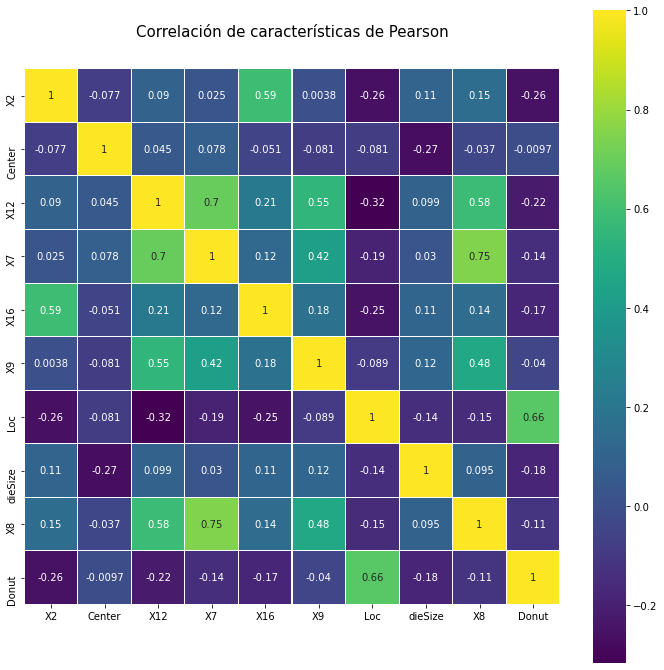

In [83]:
#para utilizar de forma conjunta rks y este
import seaborn as sb
used_features =a.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlación de características de Pearson', y=1.05, size=15)
sb.heatmap(a[used_features].astype(float).corr(),linewidths=0.1,
           vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Sabemos que la correlación va de -1 a 1 y deacuerdo al gráfico las que tiene un grado de corrlación grande son las variables 'X7' con 'X8' con indice de 0.75 y 'X7' y 'X12'.

Vamos eliminar esta dichas variables

In [84]:
data_corre=a[used_features]
data_corre=data_corre.drop(columns=['X7','X8','X12'])

Nuetra nueva data es 'data_corre' como variables independiente y Y como variable dependiente. Asi que la nueva data sera X

In [85]:
X=data_corre
y=b

# Evaluación del modelo

En esta etapa, teniendo la data totalmente procesada, se hará una copia con las variables que servirán
para predecir la variable objetivo. Separando de esta data un 80% de los valores para entrenamiento y un
20% para el testeo. En base a estos 2 grupos se podrá definir que tan bien podemos realizar la predicción.

In [86]:
from sklearn.model_selection import train_test_split
#dividir 20 y 80 y random state aleatoria para la replicabilidad de la muestra

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)


Ahora vamos a analisar con los distintios algoritmos de clasificación. Antes imporatamos algunas librerias que utilizaremos

In [87]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder,normalize,MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve

Algunos hiperparametro fueron dados a fin de maximizar ver la variabilidad de los resultados.

In [93]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
Y_pred=logistic_regression.predict(X_test)

In [94]:
SVClassifier = SVC(kernel= 'linear', degree=3, max_iter=10000, C=2, random_state = 55)
SVClassifier.fit(X_train,y_train)

C:\Users\kaize.MSI\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=2, kernel='linear', max_iter=10000, random_state=55)

In [95]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', algorithm = 'brute')
KNeighborsModel.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')

In [96]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy', max_depth = None, 
                                           splitter='best', random_state=10)
decisionTreeModel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [97]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [98]:
gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance', learning_rate = 0.01,
                                                   n_estimators = 100, max_depth = 30, random_state=10)
gradientBoostingModel.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=30, random_state=10)

In [99]:
SGDClassifier=SGDClassifier(loss = 'hinge', penalty = 'l1', learning_rate = 'optimal',
                              random_state = 10, max_iter=100)
SGDClassifier.fit(X_train,y_train)

C:\Users\kaize.MSI\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(max_iter=100, penalty='l1', random_state=10)

In [100]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

BernoulliNB(alpha=0.1)

In [101]:
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)

GaussianNB()

In [102]:
XGB_Classifier = XGBClassifier(objective='binary:logistic',max_depth=15,
                         n_estimators=10,seed=4)
XGB_Classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=4,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Accuracy de Modelos

De la tabla presentada arriba el accuracy de Regesion Logistica tiene mas sentido, por que evita un sobreajuste como lo hacen KNeighborsClassifier o RandomForestClassifier o GradienteBoostingClassifier y por otro lado SGDClassifier indica un subajuste junto con SVC.

In [103]:
models = [logistic_regression, SVClassifier, KNeighborsModel, decisionTreeModel,
          random_forest, gradientBoostingModel, bernoulliNBModel, gaussianNBModel, 
          XGB_Classifier, SGDClassifier]

rows = [[type(model).__name__, model.score(X_train, y_train),
         model.score(X_test, y_test),
         f1_score(y_test,model.predict(X_test))] for model in models]
resultado_1 = pd.DataFrame(rows, columns=["MODELO", "Train Score","Test Score", "F1-score"])
resultado_1 = resultado_1.set_index("MODELO")
resultado_1

Train Score  Test Score  F1-score
MODELO                                                       
LogisticRegression             0.742969    0.720000  0.775776
SVC                            0.475156    0.469375  0.288349
KNeighborsClassifier           0.982812    0.930625  0.941854
DecisionTreeClassifier         0.985313    0.951875  0.959452
RandomForestClassifier         0.983437    0.955000  0.962145
GradientBoostingClassifier     0.985313    0.952500  0.959958
BernoulliNB                    0.630156    0.600625  0.624339
GaussianNB                     0.650156    0.630625  0.628536
XGBClassifier                  0.981719    0.946875  0.955567
SGDClassifier                  0.401250    0.405000  0.000000

De la tabla mostrada arriba, el modelo elegido por mi sera el de Regression Logistica debido al hecho de que los demas modelos subre un sobreajuste o subajuste. (Aunque realizando mas pruebas con hiperparametros podria obtener mejores resultados)

## Métricas

### Gini en train y test

In [105]:
#Gini:
from sklearn.metrics import roc_auc_score
gini_train= 2*roc_auc_score(y_train,logistic_regression.predict_proba(X_train.values)[:,1]) -1
gini_test= 2*roc_auc_score(y_test,logistic_regression.predict_proba(X_test.values)[:,1]) -1
print("-Gini train:", round(gini_train,2))
print("-Gini test:", round(gini_test,2))

-Gini train: 0.6
-Gini test: 0.54


Ajustando el modelo para predicción

In [107]:
y_pred = logistic_regression.predict(X_test)

### Matriz de confusión

Con eso se puede obtener la matriz de confusión

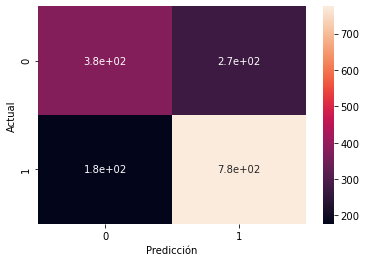

In [108]:
import seaborn as sn

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicción'])
sn.heatmap(confusion_matrix, annot=True)

Con un threshold=0.5

In [110]:
#Matriz confusion:
probs = logistic_regression.predict_proba(X_test)[:,1:]
m=pd.DataFrame(probs,columns = ['Probs'])
Y2=y_test.reset_index()
Y2['Probs']=m
threshold = 0.5
Y2["prediction"]=np.where(probs>threshold, 1, 0)
confusion_matrix = pd.crosstab(Y2.prediction, Y2.Y)
confusion_matrix

Y             0    1
prediction          
0           377  177
1           271  775

### Curva ROC

<ipython-input-115-59d79beed6d1>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


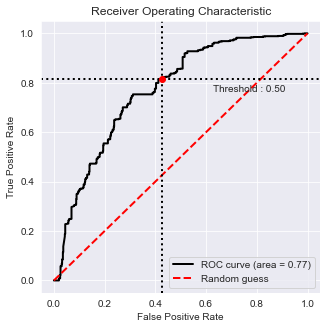

In [115]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y2["Y"], Y2["Probs"], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### Métricas adicionales

Tambien algunas metricas importantes de análisis

In [116]:
from sklearn.metrics import accuracy_score,classification_report

print(accuracy_score(y_test,y_pred).round(4)*100,'\n')

print(pd.crosstab(y_test,y_pred),'\n')

print(classification_report(y_test,y_pred),'\n')

72.0 

col_0    0    1
Y              
0      377  271
1      177  775 

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       648
           1       0.74      0.81      0.78       952

    accuracy                           0.72      1600
   macro avg       0.71      0.70      0.70      1600
weighted avg       0.72      0.72      0.72      1600
 



Se observa que del modelo se obtiene que los resultados de la data de entrenamiento dan valores de 0.74
de Accuracy y de 0.6 de Gini. De manera similar se obtiene que para la data de testeo es accuracy es
de 0.72 y el Gini de 0.54.

# APLICACIÓN DE CLUSTERS

# K-MEDIAS

Es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano.

Importamos las librerias que vamos a utilizar

In [117]:
from sklearn.cluster import KMeans

In [160]:
#rando_state replicable
estimador_kmedias = KMeans(random_state=42, n_clusters=3) #3 cluster por que solo se cuenta con 6 variables

estimador_kmedias.fit(X)

KMeans(n_clusters=3, random_state=42)

Dado que es aprendizaje supervisado, nos interesan las clases (los clusters) de los datos de entrenamiento.

In [161]:
clusters = estimador_kmedias.labels_
clusters

array([0, 0, 0, ..., 1, 1, 1])

No obstante, como cualquier estimador, podemos usarlo para asignar clusters a nuevos elementos.

In [162]:
#misma data
estimador_kmedias.predict(X)

array([0, 0, 0, ..., 1, 1, 1])

In [163]:
Target=pd.DataFrame(data=estimador_kmedias.predict(X), columns = ['Cluster'])
Target.head()

Cluster
0        0
1        0
2        0
3        0
4        0

Adjuntamos los clusters al dataframe principal X

In [164]:
X_2=pd.concat([X, Target], axis=1)
X_2.head()

X2    Center       X16     X9           Loc  dieSize         Donut  \
0  1.477667  0.012218  0.924183  105.0  5.125390e-07   1507.0  5.778933e-10   
1  1.477667  0.012218  0.924183  105.0  1.960759e-05   1129.0  1.084093e-06   
2  1.477667  0.012218  0.924183  200.0  1.081706e-04    776.0  6.231705e-07   
3  1.477667  0.012218  0.924183  200.0  4.475594e-04    776.0  2.046773e-05   
4  1.477667  0.012218  0.924183  200.0  3.271907e-04    776.0  2.869377e-06   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0

La relacion para obtener la agrupación es basicamente entre la medida del troncal 'dieSize' y el tipo de oblea que puede ser de tipo 'Center', 'Loc', y 'Donut'

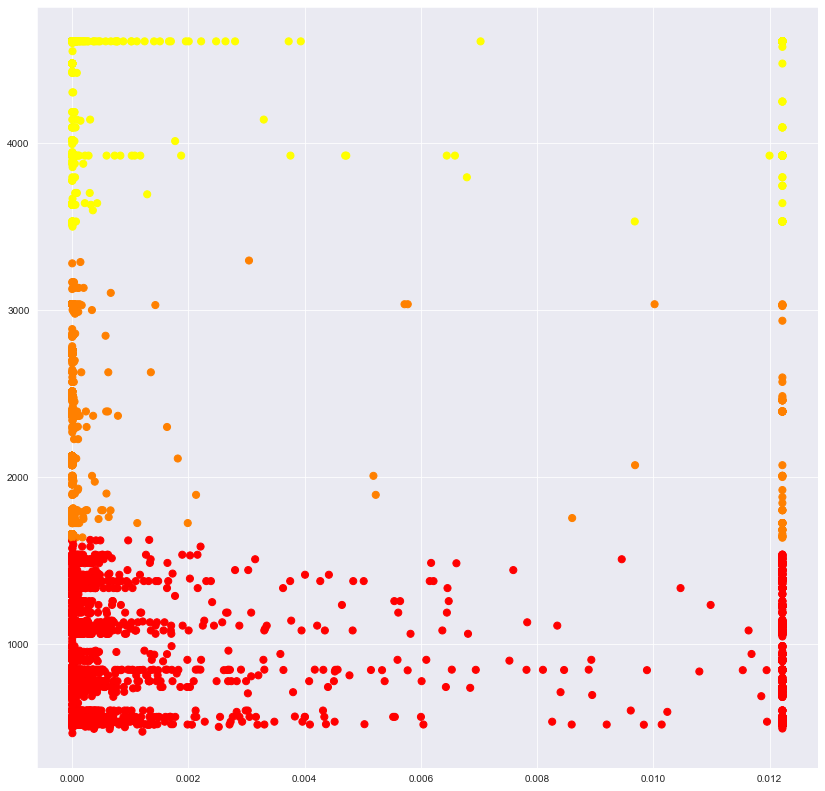

In [165]:
plt.scatter(X_2["Center"], X_2["dieSize"], c = X_2["Cluster"], s = 50, cmap="autumn")

Ahora proseguimos a calcular los centroides

In [166]:
centroides = estimador_kmedias.cluster_centers_
centroides

array([[ 2.51160644e-02,  3.83911289e-03,  2.72312279e-02,
         1.72422306e+02,  2.18438746e-03,  8.99894124e+02,
         8.05900671e-06],
       [ 2.45105887e-01,  5.52030640e-04,  1.12657864e-01,
         1.76075448e+02,  5.50831178e-04,  2.35904220e+03,
         1.86182662e-06],
       [-3.41045888e-02,  1.79564711e-03,  1.63418008e-01,
         1.91582638e+02,  1.36329721e-03,  4.26964441e+03,
         3.16060499e-06]])

In [167]:
centroides.shape

(3, 7)

Podemos ver también la inercia final de los cluster

In [168]:
estimador_kmedias.inertia_

1098875271.4366107

Se obtubo una relacion muy extraña eso debe ser debido a que no se encuentran muy aglomerados entre si.

Una pequeña acotación sobre los hiperparámetros más importantes del algoritmo `KMeans`:

- **n_clusters**: El número de clusters a crear, o sea **K**. Por defecto es 8
- **max_iter**: Máximo número de iteraciones para llegar al criterio de parada.
- **tol**: Tolerancia para declarar criterio de parada (cuanto más grande, antes parará el algoritmo).


In [169]:
from sklearn.metrics import euclidean_distances

In [170]:
distancias_centroides = euclidean_distances(centroides)
distancias_centroides

array([[   0.        , 1459.1526679 , 3369.80475911],
       [1459.1526679 ,    0.        , 1910.66515909],
       [3369.80475911, 1910.66515909,    0.        ]])

In [171]:
list(zip(np.argmax(distancias_centroides, axis=1), np.max(distancias_centroides, axis=1)))

[(2, 3369.8047591134437), (2, 1910.6651590878732), (0, 3369.8047591134437)]

Definiremos una funcion para k-means y para un resumen de grafico clustering

In [172]:
def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def resumen_grafico_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [177]:
cluster_results = kmeans_cluster(X_2, 3)
cluster_summary = resumen_grafico_clustering(cluster_results)

In [178]:
cluster_summary

Center     Donut       Loc       X16        X2          X9  \
Cluster                                                                 
0        0.003839  0.000008  0.002184  0.027231  0.025116  172.422306   
1        0.000552  0.000002  0.000551  0.112658  0.245106  176.075448   
2        0.001796  0.000003  0.001363  0.163418 -0.034105  191.582638   

             dieSize  
Cluster               
0         899.894124  
1        2359.042199  
2        4269.644407

Para visualizar mejor vamos a graficar una matrix de correlacion

In [179]:
plt.rcParams['figure.figsize'] = [14, 14]

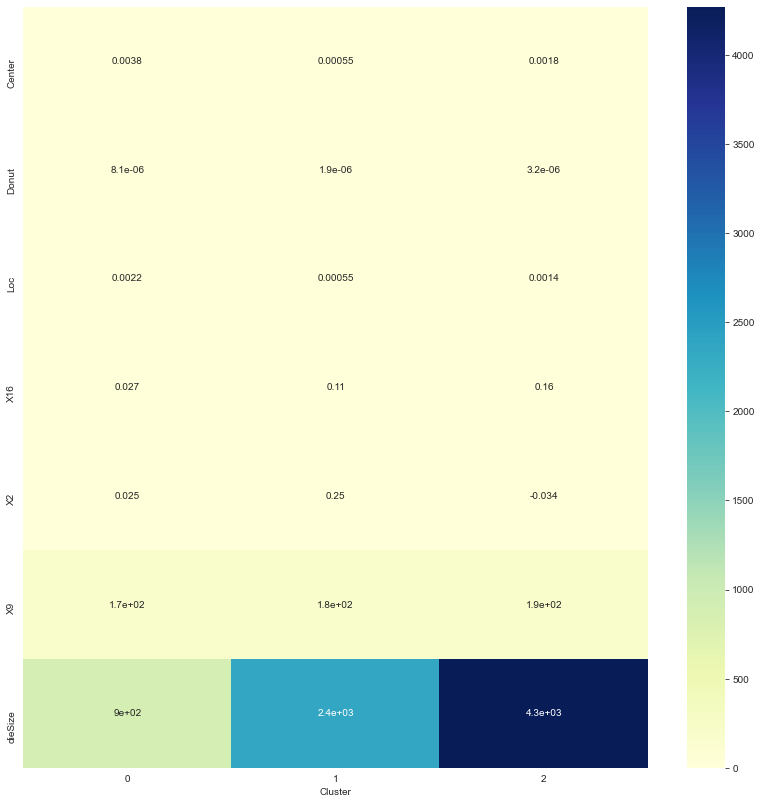

In [180]:
import seaborn as sns
sns.heatmap(cluster_summary.transpose(), annot=True,cmap="YlGnBu");

Esta matriz indica para 3 clusters hay una fuer correlacion entre 'dieSize' y que los datos son mayoes en comparación con las demas variables

### MiniBatchKMeans

Ahora vamos a probar con otro metodo parecido para comparar su velocidad de respuesta


`scikit-learn` tiene una implementación distinta del algoritmo K-medias, llamada `MiniBatchKMeans`. Esta implementación procesa el dataset por bloques, y permite hacer análisis de clusters con datasets que no cabrían en memoria completamente. Funciona de forma más rapida que `KMeans` con el coste de potencialmente producir clusters con una inercia mayor.

La api es la misma, simplemente toma un parámetro adicional `batch_size` que indica cuantos elementos tomar en cada bloque.

In [183]:
from sklearn.cluster import MiniBatchKMeans

In [196]:
%%timeit -n 1
estimador_kmedias = KMeans(random_state=42, n_clusters=3).fit(X_2)

91.3 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Es rapido comparado a k-means

In [197]:
estimador_kmedias.inertia_

1098875271.4366107

In [198]:
%%timeit -n 1
estimador_kmedias_2 = MiniBatchKMeans(random_state=42, n_clusters=3).fit(X_2)
estimador_kmedias_2

The slowest run took 6.73 times longer than the fastest. This could mean that an intermediate result is being cached.
75.3 ms ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [202]:
# recomendacion del profesor- para big data es mas optima a nivel de procesamiento
estimador_kmedias_2 = MiniBatchKMeans(random_state=42, n_clusters=3).fit(X_2)
estimador_kmedias_2

MiniBatchKMeans(n_clusters=3, random_state=42)

In [203]:
estimador_kmedias_2.inertia_

1159934136.5735626

In [204]:
#se ganos algo mas en el procesamiento
estimador_kmedias_2.inertia_/estimador_kmedias.inertia_

1.055564873215435

Vemos que MiniBatchKMeans produce unos clusters con un 8% más de inercia. En este caso no hay mejora de tiempo por que el dataset es pequeño (36,000 observaciones).

# Elección de K

Hay varias opciones para elegir K

**1.Conocimiento de dominio**
A veces es posible tomar una decisión razonable a priori respecto al número de clusters que queremos. Por ejemplo, si queremos hacer una campaña de marketing podemos definir a priori cuantas clases desearíamos tener

**2. Decisión de negocio**
Hay veces que la decisión del número de clusters viene dada por el negocio. Por ejemplo, supongamos que estamos agrupando un conjunto de invitados a un banquete. En ese caso el valor de K vendría dado por el número disponible de mesas.

**3.Método del codo**
El método del codo usa como métrica el porcentaje de la varianza explicado como factor respecto al número de clusters. Se intenta buscar aquel número de clusters donde el añadir un cluster más no aumente demasiado dicho porcentaje (es decir, el "codo" de la gráfica que representa esto implica llegar al punto de ganancias decrecientes, donde añadir un cluster nuevo no reduce la varianza de forma significativa.
El porcentaje de la varianza se representa como la variance entre grupos dividida de la varianza total

In [205]:
from scipy.spatial.distance import cdist

In [206]:
varianza_total = cdist(XA=X_2, XB=np.array([X_2.mean()]))
suma_varianza_total = varianza_total.sum()
suma_varianza_total

6350935.231446861

Ahora creamos funciones para calcular varianza intra cluster (wss) y la medida de varianza explicada (definida como la reduccion de la varianza en porcentaje respecto a la varianza máxima (que sería la varianza para k=1).

In [207]:
def varianza_cluster(cluster_id, centroide_cluster, etiquetas_clusters):
    elementos_cluster = X_2[etiquetas_clusters==cluster_id]
    return cdist(XA=elementos_cluster, XB=np.array([centroide_cluster])).sum()

def medida_varianza(estimador_kmedias, suma_varianza_total):
    etiquetas_clusters = estimador_kmedias.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(etiquetas_clusters)):
        centroide_cluster = estimador_kmedias.cluster_centers_[i]
        wss += varianza_cluster(cluster_id, centroide_cluster, etiquetas_clusters)
    return (suma_varianza_total-wss) / suma_varianza_total

#### Utilizamos ahora otra medida de evaluación que simplemente usa la inercia

In [208]:
def medida_inercia(estimador_kmedias):
    return estimador_kmedias.inertia_

In [209]:
def evaluar_k_kmedias(k, medida, **kwargs):
    if medida=="inercia":
        funcion_medida = medida_inercia
    elif medida=="varianza":
        funcion_medida = medida_varianza
        
    estimador_kmedias = KMeans(random_state=42, n_clusters=k)
    estimador_kmedias.fit(X_2)
    return funcion_medida(estimador_kmedias, **kwargs)

In [211]:
resultados_k = {}
rango_k = [1, 3, 6, 9, 12, 15, 18, 21, 24]
for k in rango_k:
    resultados_k[k] = evaluar_k_kmedias(k, 
                                "inercia"), evaluar_k_kmedias(k, "varianza", 
                                                              suma_varianza_total=suma_varianza_total)

Ahora los resultados

In [212]:
resultados_k
#columna 2 es la varianza

{1: (8918907909.827213, -1.3197903719811283e-15),
 3: (1098875271.4366107, 0.5878285122459299),
 6: (212864597.24681732, 0.8333001787812214),
 9: (77673188.68020031, 0.8967617905836675),
 12: (48750071.64335397, 0.9166101849651587),
 15: (33194090.05632227, 0.9318308458890999),
 18: (26875298.426417537, 0.9391031142302312),
 21: (22752907.07899649, 0.9438524375778182),
 24: (19054222.21549328, 0.9513689085054451)}

Ahora hacemos una gráfica para ver donde está el "codo" de forma aproximada.

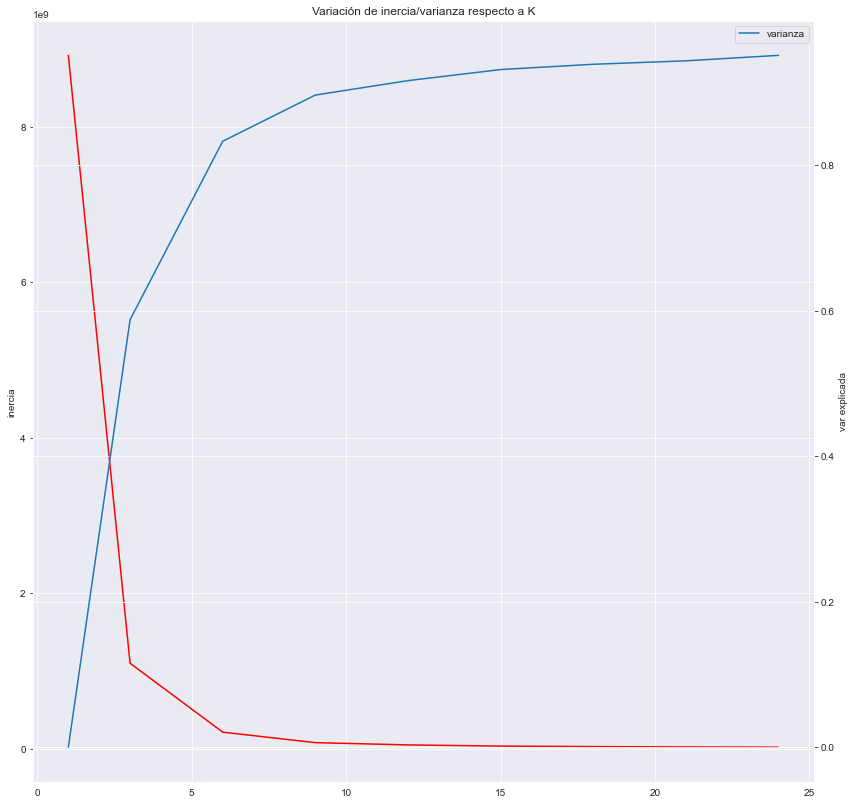

In [213]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in resultados_k.items()],
    [c[1][0] for c in resultados_k.items()], label="inercia", color="red")
ax1.set_ylabel('inercia')

ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in resultados_k.items()],
    [c[1][1] for c in resultados_k.items()], label="varianza")
ax2.set_ylabel('var explicada')

plt.xlabel("K")
plt.legend()
plt.title("Variación de inercia/varianza respecto a K");

Para este caso en concreto, un valor de K=3 o 5, podria ser una buena opción si no hubiese ningún otro requisito.

### Medidas de evaluación externa

### Indice de RAND

In [214]:
#evaluacion con un target particular
from sklearn.metrics import homogeneity_completeness_v_measure, adjusted_rand_score

homogeneidad, la completación y la medida v (0 a 1)

Ahora seleccionamos la clase que en este caso seria Y

In [216]:
#clase (real) cluster la (prediccion)
homogeneity_completeness_v_measure(y, X_2["Cluster"])

(0.02769561319717118, 0.025111247442742426, 0.026340190939015302)

Mas altos estos valores resultan mejores

In [217]:
np.unique(y)

array([0, 1], dtype=int64)

Por tanto EL INDICE DE RAND SERA:

In [218]:
adjusted_rand_score(y, X_2["Cluster"])

-0.015047060664630123

#### Cuya validación es:

In [219]:
from sklearn.model_selection import cross_val_score

In [221]:
resultados = cross_val_score(X=X_2, y=y, estimator=KMeans(n_clusters=3), 
                             scoring="adjusted_rand_score", cv=5)
resultados.mean()

-0.02817013831265692

El hecho que sea indice de Rand negativo dice que el acuerdo es menor de lo que se espera de un resultado aleatorio. Esto significa que los resultados son 'ortogonales' o 'complementarios' hasta cierto punto.

Pero esto no debería suceder a menudo, a menos que busque deliberadamente agrupaciones alternativas. ¿Quizás hay un error de implementación.

### Medidas de evaluación interna

### Calculo del Indice SILUETA

In [222]:
from sklearn.metrics import silhouette_score

In [223]:
try:
    from sklearn.metrics import calinski_harabasz_score
except ImportError:
    from sklearn.metrics import calinski_harabaz_score

In [224]:
print("El indice de silueta será: ",silhouette_score(X_2, X_2["Cluster"]))
#más grande mejor 0 a 1

El indice de silueta será:  0.6747172161463272



La métrica de calinski-Harabaz (calinski-harabaz-score)es otra medida de evaluación interna. Nos da una medida de la dispersión dentro de un cluster y de la separación entre clusters. La diferencia con el coeficiente de silueta es que es más eficiente de calcular.

In [225]:
calinski_harabasz_score(X_2, X_2["Cluster"]) # Mayor es mejor

28454.91323480797

 En principio se verifico que el Conjunto de datos proporcionados no tenian valores Missing, luego se procedio a normalizar los valores por ser inerente para el uso de K-medias. Por otro lado, se comprobo para "Centerr" y "dieSize" por ser variables representativas para analisis de fallas en obleas y aprobación del sistema de manufactura.

Se realizó algunos cálculos iniciales para poder obtener algunos parametros de importancia tales como:
 - El calculo de indice de Rand es del orden de: -0.015
 - El calculo del coeficiente de silueta es del orden de: 0.67

Para una trabajo futuro y mas elaborado se debe escoger las variables que sean mas coherente entre si.
 

## APLICANDO DBSCAN

Primero elegimos los mejores parametros

In [226]:
from sklearn.cluster import KMeans, DBSCAN 
from sklearn import metrics
from IPython.display import Markdown
from sklearn.decomposition import PCA

In [227]:
mejores_params = {'eps': 4.9856603649238247, 'min_samples':6, 'p': 1}

In [228]:
estimador_dbscan = DBSCAN(n_jobs=-1, **mejores_params)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

### Calculo de indice de silueta

In [229]:
print("El Coeficiente de Silhouette es: %0.3f"
      % metrics.silhouette_score(X, etiquetas_dbscan))

El Coeficiente de Silhouette es: 0.734


In [230]:
etiquetas_dbscan

array([ -1,  -1,   0, ..., 128, 128, 128], dtype=int64)

### Cálculo de valores unicos -1


In [231]:
unique, counts = np.unique(etiquetas_dbscan, return_counts=True)
cantidad=dict(zip(unique, counts))
Markdown("""Los cantidad de valores encontrados son: {cantidad}""".format(cantidad=cantidad))

Los cantidad de valores encontrados son: {-1: 837, 0: 58, 1: 74, 2: 26, 3: 10, 4: 15, 5: 21, 6: 27, 7: 56, 8: 10, 9: 70, 10: 332, 11: 6, 12: 16, 13: 10, 14: 78, 15: 6, 16: 24, 17: 7, 18: 7, 19: 45, 20: 17, 21: 17, 22: 16, 23: 29, 24: 44, 25: 7, 26: 10, 27: 379, 28: 93, 29: 30, 30: 36, 31: 78, 32: 136, 33: 9, 34: 43, 35: 9, 36: 37, 37: 55, 38: 46, 39: 51, 40: 6, 41: 9, 42: 47, 43: 6, 44: 47, 45: 128, 46: 35, 47: 59, 48: 37, 49: 12, 50: 12, 51: 6, 52: 13, 53: 15, 54: 23, 55: 7, 56: 28, 57: 35, 58: 22, 59: 6, 60: 36, 61: 6, 62: 91, 63: 6, 64: 11, 65: 54, 66: 59, 67: 12, 68: 6, 69: 7, 70: 11, 71: 7, 72: 6, 73: 6, 74: 73, 75: 7, 76: 17, 77: 10, 78: 7, 79: 21, 80: 9, 81: 6, 82: 11, 83: 19, 84: 14, 85: 26, 86: 11, 87: 10, 88: 29, 89: 14, 90: 25, 91: 60, 92: 6, 93: 46, 94: 10, 95: 84, 96: 12, 97: 27, 98: 16, 99: 18, 100: 26, 101: 47, 102: 8, 103: 11, 104: 10, 105: 23, 106: 63, 107: 100, 108: 23, 109: 33, 110: 13, 111: 8, 112: 17, 113: 55, 114: 18, 115: 19, 116: 7, 117: 116, 118: 7, 119: 41, 120: 63, 121: 12, 122: 62, 123: 30, 124: 10, 125: 40, 126: 19, 127: 17, 128: 71, 129: 33, 130: 153, 131: 9, 132: 12, 133: 17, 134: 39, 135: 16, 136: 7, 137: 6, 138: 191, 139: 22, 140: 30, 141: 40, 142: 67, 143: 332, 144: 92, 145: 79, 146: 30, 147: 11, 148: 15, 149: 8, 150: 8, 151: 15, 152: 12, 153: 25, 154: 12, 155: 7, 156: 30, 157: 11, 158: 16, 159: 13, 160: 8, 161: 21, 162: 74, 163: 14, 164: 68, 165: 20, 166: 6, 167: 8, 168: 19, 169: 8, 170: 9, 171: 239, 172: 45, 173: 14, 174: 68, 175: 6, 176: 21, 177: 57, 178: 8, 179: 6, 180: 16, 181: 6, 182: 8, 183: 15, 184: 60, 185: 13, 186: 6, 187: 6, 188: 6, 189: 8, 190: 62, 191: 7, 192: 39, 193: 11, 194: 36, 195: 30, 196: 9, 197: 11, 198: 6, 199: 6, 200: 27, 201: 6, 202: 17, 203: 20, 204: 10, 205: 6, 206: 8, 207: 10, 208: 9, 209: 8, 210: 21, 211: 8, 212: 6, 213: 7, 214: 28, 215: 23, 216: 10, 217: 15, 218: 6, 219: 6, 220: 6}

Sucede algo extraño en la implementación que requiere una meticulosa revisión

#### Visualización de datos reducidos por PCA y creando funcion automatizada

Reduciendo componente a 2

In [238]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_2)
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['Pca1', 'Pca2']

Aplicando DBSCAN para verificar como sale con 2 componente

In [240]:
db = DBSCAN(eps=4.9856603649238247,min_samples=6,n_jobs=-1, p=1)
etiquetas_dbscan2=db.fit(X_principal).labels_

##### Valores encontrados "-1"

In [241]:
unique, counts = np.unique(etiquetas_dbscan2, return_counts=True)
cantidad=dict(zip(unique, counts))
print("Los cantidad de valores encontrados son: {cantidad}".format(cantidad=cantidad))

Los cantidad de valores encontrados son: {-1: 836, 0: 58, 1: 74, 2: 26, 3: 10, 4: 15, 5: 21, 6: 27, 7: 56, 8: 10, 9: 70, 10: 332, 11: 6, 12: 16, 13: 10, 14: 78, 15: 6, 16: 24, 17: 7, 18: 7, 19: 45, 20: 17, 21: 17, 22: 16, 23: 29, 24: 44, 25: 7, 26: 10, 27: 379, 28: 93, 29: 30, 30: 36, 31: 78, 32: 136, 33: 9, 34: 43, 35: 9, 36: 37, 37: 55, 38: 46, 39: 51, 40: 6, 41: 9, 42: 47, 43: 6, 44: 47, 45: 128, 46: 35, 47: 59, 48: 37, 49: 12, 50: 12, 51: 6, 52: 13, 53: 15, 54: 23, 55: 7, 56: 28, 57: 35, 58: 22, 59: 6, 60: 36, 61: 6, 62: 91, 63: 6, 64: 8, 65: 11, 66: 54, 67: 59, 68: 12, 69: 6, 70: 11, 71: 7, 72: 6, 73: 6, 74: 73, 75: 7, 76: 17, 77: 10, 78: 7, 79: 21, 80: 9, 81: 6, 82: 11, 83: 19, 84: 14, 85: 26, 86: 11, 87: 10, 88: 29, 89: 14, 90: 25, 91: 60, 92: 6, 93: 46, 94: 10, 95: 84, 96: 12, 97: 27, 98: 16, 99: 18, 100: 26, 101: 47, 102: 8, 103: 11, 104: 10, 105: 23, 106: 63, 107: 100, 108: 23, 109: 33, 110: 13, 111: 8, 112: 17, 113: 55, 114: 18, 115: 19, 116: 7, 117: 116, 118: 7, 119: 41, 12

##### Calculo de coeficiente de silhoette

In [242]:
print("El Coeficiente de Silhouette es: %0.3f"
      % metrics.silhouette_score(X_principal, etiquetas_dbscan2))

El Coeficiente de Silhouette es: 0.746


### Funcion PCA para gráfica

Para facilitar el trabajo realizaremos una función de tal manera de clasificar mejor a las variables y ahorrar tiempo

In [243]:
def dbscan(data, eps, min_samples,n_jobs,p):
    # Elegimos 2 componentes para graficar
    pca = PCA(n_components = 2) 
    X_principal = pca.fit_transform(data)
    X_principal = pd.DataFrame(X_principal) 
    X_principal.columns = ['Pca1', 'Pca2']
    # Realizamos un analisis DBSCAN a los datos
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs,p=p)
    db=db.fit(X_principal)
    y_pred = db.fit_predict(X_principal)
    plt.scatter(X_principal["Pca1"], X_principal["Pca2"],c=y_pred, cmap='Paired')
    plt.title("Grafico de dispersion de datos por DBSCAN")

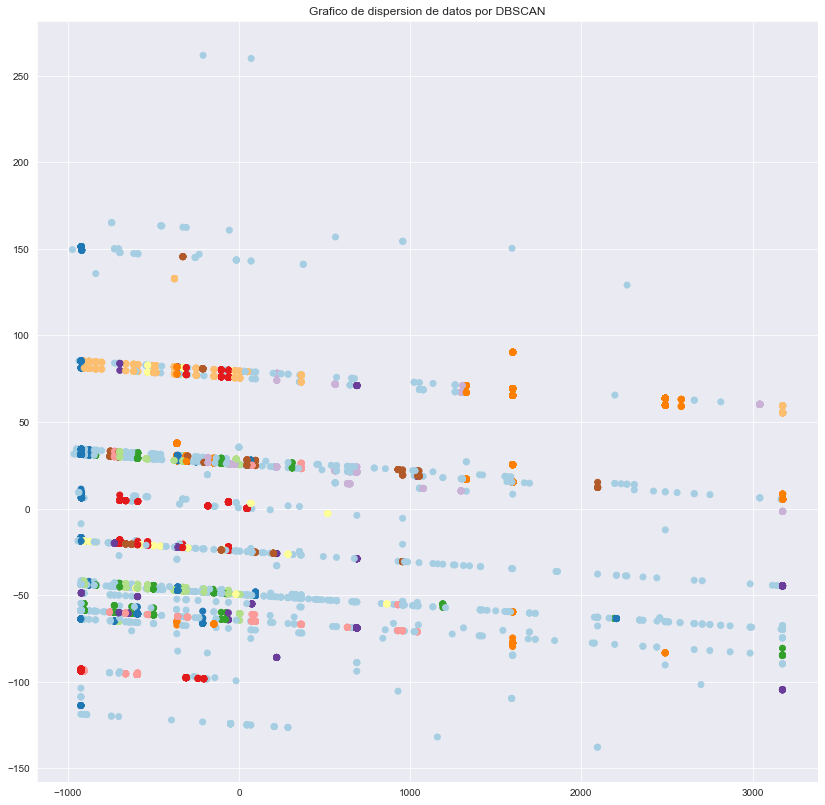

In [244]:
dbscan(X_2,eps=4.9856603649238247,min_samples=6,n_jobs=-1, p=1)

Conclusiones
Se logro calcular el indice de silueta con los parametros mejores_params = 'eps': 4.9856603649238247, 'min_samples':6, 'p': 1 
para detectar anamalias usando DBSCAN.

- El número de anomalias detectadas fueron de: No se tiene claro debido al modelo incial con el que se partio.

- El indice de silueta calculado fue de: 0.74

# Pruebas con Redes Neuronales

# Propagación hacia atrás

Usamos solo las 4 primeras variables para que el input coincida con la capa de entrada de la red

In [264]:
X_3=X_2.copy()
X_3=X_3.drop(columns=['X2','X9','Cluster','dieSize'])
X_3

Center       X16           Loc         Donut
0     1.221805e-02  0.924183  5.125390e-07  5.778933e-10
1     1.221805e-02  0.924183  1.960759e-05  1.084093e-06
2     1.221805e-02  0.924183  1.081706e-04  6.231705e-07
3     1.221805e-02  0.924183  4.475594e-04  2.046773e-05
4     1.221805e-02  0.924183  3.271907e-04  2.869377e-06
...            ...       ...           ...           ...
7995  7.860807e-12 -0.496959  4.395741e-16  8.238234e-18
7996  3.136740e-05 -0.496959  3.013684e-06  1.375660e-10
7997  2.121396e-09 -0.496959  2.035249e-13  2.659862e-17
7998  8.457914e-20 -0.496959  5.367670e-21  9.804817e-25
7999  3.995504e-08 -0.496959  3.372209e-16  4.552690e-19

[8000 rows x 4 columns]

## Creación de la red neuronal

Vamos a crear la siguente red neuronal

E implementaremos el algoritmo de propagación hacia atrás (backpropagation) que es lo que permitirá que la red aprenda.

Es decir, una capa de entrada con 4 neuronas (*también llamadas unidades^), una capa oculta con 5 neuronas y una capa de salida que convertirá los outputs (o activaciones de la capa oculta en clase positiva o negativa

En primer lugar definimos las funciones de activación distintas:

- Función identidad, que se usa en la capa de entrada y no hace nada (o sea,  f(x)=x ) (simplofocar calculos entre capas)
- Función Sigmoide, que aplica la función sigmoide  f(x)=11+e−x  que convierte los números al rango [0,1] y que se usa para problemas de clasificación binaria (probabilidad)

In [265]:
y_3=b

In [266]:
x1 = X_3.values
x0=x1[0]
y0 = y_3[0]
print(x0, y0)

[1.22180497e-02 9.24183241e-01 5.12538975e-07 5.77893344e-10] 1


Definimos las funciones activadoras para la red

In [267]:
def fn_identidad(x, derivada=False):
    if derivada:
        return np.ones(x.shape)
    return x
                
def fn_sigmoide(x, derivada=False):
    if derivada:
        return x*(1-x)
    return 1/(1+np.exp(-x))

también tenemos que definir una manera de computar el error de una predicción (error, coste y perdida se usan indistintamente).

Para un problema de clasificación binaria, una buena métrica es la pérdida logarítmica (logloss)

In [268]:
def error_logloss(y_pred, y):
    p = np.clip(y_pred, 1e-15, 1 - 1e-15) #notacion cientifica
    if y == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p) 

En primer lugar, definimos la capa básica, que tiene un número de unidades un bias, y una función de activaciónr

In [269]:
class Layer:
    def __init__(self, n_unidades, fn_activacion, bias=True):
        self.n_unidades = n_unidades
        self.fn_activacion = fn_activacion
        self.dim_output = n_unidades
        
        # añadimos un peso más para la unidad de bias
        self.bias = bias

        self.dimensiones = "no generada"
        self.w = None
        
    def __repr__(self):
        return """
        Capa {}. dimensiones = {}.
        pesos: {}
        """.format(
        self.nombre, self.dimensiones, self.w)
    
    def generar_pesos(self, dim_output_anterior):
        if self.bias:
            self.dimensiones = (self.n_unidades, dim_output_anterior+1)
        else:
            self.dimensiones = (self.n_unidades, dim_output_anterior)
        self.w = np.random.random(self.dimensiones)

    def add_bias(self, x):
        if not self.bias:
            return x
        x_con_bias_1d = np.append(1, x)
        # append convierte en array 1dimensional necesitamos 2d
        return x_con_bias_1d.reshape(
             x_con_bias_1d.shape[0], 1
        )
    
    def activar(self, x):
        x_con_bias_2d = self.add_bias(x)
        return self.fn_activacion( self.w @ x_con_bias_2d )
#propagando el error a la capa
    def calcular_delta(self, producto_capa, output_capa):
        return producto_capa * self.fn_activacion(output_capa, derivada=True)

Tenemos 3 tipos de Capas de neuronas.

- Capa de Entrada, no hace nada, simplemente conecta el input con el resto de la red
- Capa Oculta, también llamada capa densa, realiza el algoritmo perceptrón con una función de activación no lineal
- Capa de Salida, esta capa traduce el output de la capa antepenúltima a la variable objetivo deseada

In [270]:
class InputLayer(Layer):
    nombre = "entrada"

    def generar_pesos(self):
        pass      
    
    def activar(self, x):
        return x

class HiddenLayer(Layer):
    nombre = "oculta"
    
class OutputLayer(Layer):
    nombre = "salida" 

Ahora creamos la red neuronal, que es simplemente una lista de capas y con capacidad de hacer propagación hacia delante y hacia atrás.


In [271]:
class RedNeuronal:
    def __init__(self, ratio_aprendizaje, fn_error):
        self.layers = []
        self.ratio_aprendizaje = ratio_aprendizaje
        self.fn_error = fn_error
        
    def add_layer(self, layer):
        if layer.nombre == "entrada":
            layer.generar_pesos()
        else:
            layer.generar_pesos(self.layers[-1].dim_output)
        self.layers.append(layer)
            
    def __repr__(self):
        info_red = ""
        for layer in self.layers:
            info_red += "\nCapa: {} Nº unidades: {}".format(
                        layer.nombre, layer.n_unidades)
        return info_red
  #hacia adelante  
    def forward(self, x):
        
        for layer in self.layers:
            layer.input = layer.add_bias(x).T
            x = layer.activar(x)
            layer.output = x
        return x
    
    def calcular_error_prediccion(self, y_pred, y):
        return self.fn_error(y_pred, y)
  # hacia atras
    def backward(self, y_pred, y):
        # El error de prediccion final
        delta_capa = self.calcular_error_prediccion(y_pred, y)
        for layer in reversed(self.layers):
            if layer.nombre == "entrada":
                continue    
            if layer.nombre == "salida":
                producto_capa = delta_capa @ layer.w
            else:
                #quitamos el error del bias de la capa anterior
                producto_capa = delta_capa[:,1:] @ layer.w
            delta_capa = layer.calcular_delta(producto_capa, layer.output) 
            layer.delta = delta_capa       
                   
                
    def actualizar_pesos(self):
        """
        Actualiza pesos mediante el descenso de gradiente"""
        for layer in self.layers[1:]:
            layer.w = layer.w - self.ratio_aprendizaje \
                      *layer.delta * layer.input

    def aprendizaje(self, x, y):
        """
        Función principal para entrenar la red
        """
        y_pred = self.forward(x)
        self.backward(y_pred, y)
        self.actualizar_pesos()
        error_prediccion = self.calcular_error_prediccion(y_pred, y)
        return error_prediccion

    def predict_proba(self, x):
        return self.forward(x)
    
    def predict(self, x):
        probabilidad = self.predict_proba(x)
        if probabilidad>=0.5:
            return 1
        else:
            return 0

## Creación de la red neuronal

En primer lugar tenemos que definir los tamaños de cada capa, y si van a incluir sesgo (bias) o no.

In [272]:
n_input = 4
n_oculta = 5
n_output = 1
#hiperparametros
RATIO_APRENDIZAJE = 0.0001
N_ITERACIONES=1000

In [273]:
red_sigmoide = RedNeuronal(ratio_aprendizaje=RATIO_APRENDIZAJE, fn_error=error_logloss)

red_sigmoide.add_layer(InputLayer(n_input, bias=False, fn_activacion=fn_identidad))
red_sigmoide.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_sigmoide))
red_sigmoide.add_layer(OutputLayer(n_output, fn_activacion=fn_sigmoide))

Inicialmente la red tiene unos pesos aleatorios

In [274]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.85331424 0.84251593 0.993586   0.73683173 0.50016255]
  [0.71010467 0.07182256 0.58676402 0.58163666 0.73515374]
  [0.66181206 0.35032482 0.34699283 0.95795784 0.4080359 ]
  [0.31276662 0.44872597 0.70711942 0.75397289 0.07092472]
  [0.74268957 0.10475369 0.40015677 0.94623575 0.91005116]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.61911223 0.03783661 0.97993805 0.97404946 0.22441449 0.66187375]]
         ]

In [275]:
red_sigmoide.aprendizaje(x0, y0)

array([[0.05993424]])

Vemos que los pesos de las capas se han actualizado

In [276]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.85331416 0.84251593 0.99358595 0.73683173 0.50016255]
  [0.71010456 0.07182256 0.58676395 0.58163666 0.73515374]
  [0.66181193 0.35032482 0.34699275 0.95795784 0.4080359 ]
  [0.31276649 0.44872597 0.70711933 0.75397289 0.07092472]
  [0.74268945 0.10475369 0.4001567  0.94623575 0.91005116]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.61911203 0.0378366  0.9799378  0.97404923 0.22441444 0.66187359]]
         ]

Esto es el equivalente a hacer los siguientes pasos

In [277]:
#hacia adelante (prediccion)
prediccion = red_sigmoide.forward(x0)
prediccion

array([[0.94182642]])

In [278]:
#hacia atras en base a esa predicción (utiliza esa predccion para atras)
red_sigmoide.backward(prediccion, y0)

In [279]:
#actualizamos los pesos
red_sigmoide.actualizar_pesos()

In [280]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.85331408 0.84251593 0.9935859  0.73683173 0.50016255]
  [0.71010445 0.07182256 0.58676388 0.58163666 0.73515374]
  [0.66181181 0.35032482 0.34699267 0.95795784 0.4080359 ]
  [0.31276637 0.44872597 0.70711925 0.75397289 0.07092472]
  [0.74268933 0.10475369 0.40015662 0.94623575 0.91005116]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.61911182 0.03783659 0.97993755 0.97404899 0.22441439 0.66187342]]
         ]

Ya tenemos una red neuronal que aprende para optimizar una observación usando el método del descenso de gradiente. Ahora solo tenemos que implementar el método de descenso estocástico de gradiente (SGD) para iterar en todo el dataset de entrenamiento e ir modificando los pesos para minimizar los errores de entrenamiento


In [281]:
def iteracion_sgd(red, X, y):
    # seleecionamos aleatoriament los datos de entrenamiento
    indice_aleatorio = np.random.permutation(X.shape[0])
    error =  []
    # iteramos todo el dataset
    for i in range(indice_aleatorio.shape[0]):
        x0 = X[indice_aleatorio[i]]
        y0 = y[indice_aleatorio[i]]
        err = red.aprendizaje(x0, y0)
        error.append(err)
    return np.nanmean(np.array(error))

def entrenar_sgd(red, n_epocas, X, y):
    epocas = []
    for epoca in range(n_epocas):
        error_epoca = iteracion_sgd(red, X, y)
        epocas.append([epoca, error_epoca])
    return np.array(epocas)

Ahora por ejemplo corremos el algoritmo durante varias iteraciones.


In [282]:
resultados_sigmoide = entrenar_sgd(red_sigmoide, N_ITERACIONES, x1, y)

Si ahora visualizamos la evolución del error medio

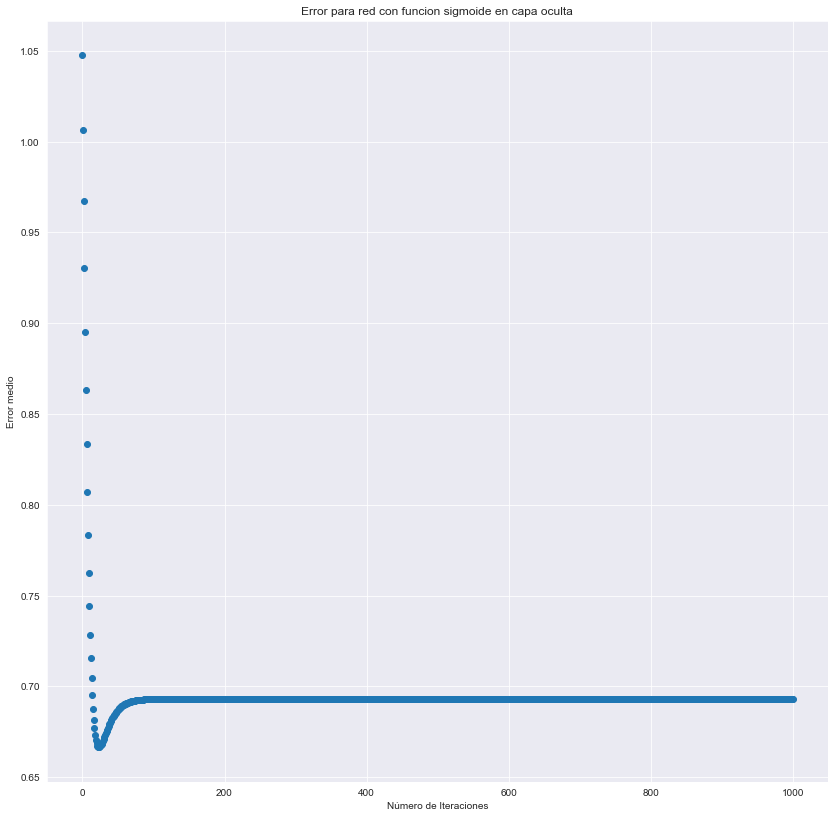

In [283]:
plt.scatter(x=resultados_sigmoide[:,0], y=resultados_sigmoide[:,1])
plt.title("Error para red con funcion sigmoide en capa oculta")
plt.xlabel("Número de Iteraciones")
plt.ylabel("Error medio");
#sobre los hiperametros numero optimo seria 200

Vemos que a cada iteración (época) de aprendizaje el error medio total se va reduciendo

Lo bueno de las redes neuronales es que tienen una flexibilidad que otros modelos no tienen.

Por ejemplo podemos cambiar la función de activación de la capa oculta.

En la práctica la función sigmoide no se usa para capas ocultas, se suele usar más la Unidad Linear rectificada (ReLU).

In [284]:
def fn_relu(x, derivada=False):
    if derivada:
        return 1. * (x>0.)
    return np.maximum(x, 0.)

def fn_leakyrelu(x, derivada=False):
    if derivada:
        if x.any()>0:
            return 1.
        else:
            return 0.01
    return np.maximum(x, 0.01*x)

o incluso modificar la red y añadir otra capa con el doble de unidades

In [285]:
red_relu = RedNeuronal(ratio_aprendizaje=RATIO_APRENDIZAJE, fn_error=error_logloss)
red_relu.add_layer(InputLayer(n_input, bias=False, fn_activacion=fn_identidad))
#2 capas ocultas
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(OutputLayer(n_output, fn_activacion=fn_sigmoide))

# en esta estamos usando la gfuncion relu

In [286]:
resultados_relu = entrenar_sgd(red_relu, N_ITERACIONES, x1, y)


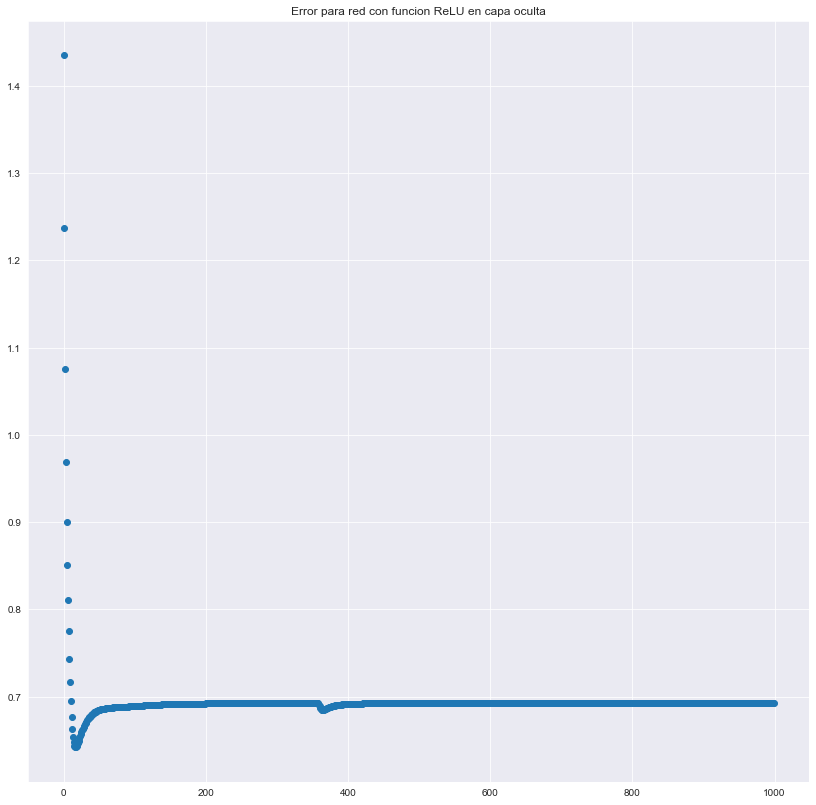

In [287]:
plt.scatter(x=resultados_relu[:,0], y=resultados_relu[:,1])
plt.title("Error para red con funcion ReLU en capa oculta");
# recomendable regreseion logistica

# Conclusiones

En la Primera Parte de la monografía, se hizo una breve introducción en lo que respecta al manufactura de chips o dispositivos semiconductores y como es que recolectan los datos en empresas bien establecidas en ese área. En la segunda parte, se realiza la exploración de datos, como la obtención y el tratamiento de estos datos previamente previamente comprendiendo la problemática en cuanto la toma de decisiones o predicción de aprobación o desaprobación del material manufacturado y como influye en el coste operativo el cual puede ser aprovechado enormemente evitando degradamiento en los mismos. Por otro lado, el aprendizaje supervisado ayuda bastante en cuanto a la identificación de variables, realizándose un correcto tratamiento de información verificando los valores Faltantes o missing y Atípicos Outliers cabe mencionar que se selecciono el metodo Boxplot o por cuartiles por ser mas practico para implementar.

En cuanto a la selección de variables se escogieron método trabajado en clase que resultaron bastantes prácticos y relativamente simples de implementar tales como el WOE y IV para variables categóricas y continuas al igual que el indicie de gini individual, además, se utilizo una librería mas trabajada para selección de variables mediante WOE, randomForest, CHicuadrado, entre otros, dando como resultado una selección "por quien tiene mas fallas". Esta ultima función también proporciona la conversión de variables dummies en función a sus índices calculados. Para agregar se utilizo las funciones de KBest y la técnica de correlación que ayudaron a reducir variables a 7 como data final.

Una vez seleccionada la data, se procedió a probar los distintos modelos de selección de las cuales se eligió el modelo de regresión logística donde se siguió el criterio de evitar sobreajuste y subajuste. El accuracy obtenido para este modelo fue de 0.74 en train y 0.72  en test. Mientras que el índice de gini fue de 0,6 en train y 0,54 en test. se calculo de igual manera algunas métricas adicionales y la curva de ROC DANDO 0,77.

Se aplico clusters K-Medias y DBSCAN, donde se calcularon el numero de cluster igual a 3 por el método de codo.

Como ultima prueba se realizo pruebas con Redes Neuronales eligiendo las variables mas representativas de nuestra data que basicamente son los distintos tipos de fallas de obleas.

En conclusión final se puede decir que los modelos de clasificación ayudan en cuanto a la predicción de aprobación o desaprobación de semiconductores obtenido por tasa de rendimiento de una combinación específica de máquina-producto y tipo de oblea durante la producción de un semiconductores y posiblemente puedan utilizadas como nuevas herramientas para mediciones de errores fallas etc en un que necesita bastante precisión.